# 

# INSY 6500 Final Project – AURPI Interactive Sensing Systems

**Prject Team: Maram Shqair, Eman Alzyoud, and Ismail Hasan**

## Project Context

We (in AURPI) are building reliable, low-cost sensing for poultry operations. Our current validation sites are Auburn University’s BERL facility and the AU Greenhouse, with the long-term goal of transferring the technology to commercial partners. The main issues we target are:

- Erratic sensor data (flatlines, missing values, and out-of-range readings)  
- Alert failures on critical thresholds, especially for current sensors  
- Lack of preventive-maintenance logic and feedback to operations

At a high level, the program runs in four phases:

1. **Analyze historical logs** to understand sensor behavior and failure modes  
2. **Validate with parallel hardware** (independent sensing) to ground-truth readings  
3. **Remediate** by calibrating, relocating, or replacing problem sensors and improving alert logic  
4. **Deploy to partner facilities** once the sensing and analytics are robust

This project focuses on the **data analytics side** of that effort.

## Dataset Description

The dataset used in this project is extracted from the Urban.io dashboard for the **AU Greenhouse**. It contains **5,960 observations** over approximately a single day and represents time-stamped readings from multiple IoT devices.

Observed metric types include:

- **Current** (electrical load on monitored equipment)  
- **Fault** indicators  
- **Sensor battery level**  
- **Sensor signal strength**

Units include **amperes (A)**, **percent (%)**, and **Boolean/indicator values**.

The CSV file contains **19 attributes**, spanning:

- **Time**: event timestamps and arrival timestamps  
- **IDs**: device, data-stream, and location identifiers  
- **Metric info**: metric type, description, and units  
- **Values**: raw value, scaled value, and derived changes (differences and rates)  
- **Quality window and change metrics**: e.g., `dts`, `dv`, `dv_per_s`  
- **Provenance**: record type and data source

This structure is well suited for:

- Time-series cleaning and normalization  
- Data-quality checks and validation  
- Pivoting by device, metric type, or time window  
- Anomaly and fault pattern detection  
- Back-testing alert thresholds  
- Reliability analyses linking current/fault behavior to equipment state

## INSY 6500 Project Objectives

For INSY 6500, this dataset will be used to:

1. Apply a complete **Exploratory Data Analysis (EDA) workflow**: loading, reconnaissance, data-quality assessment, and cleaning.  
2. Explore **univariate and bivariate patterns** in current, faults, battery level, and signal strength across devices and time.  
3. Identify and visualize **anomalies and potential reliability issues**, such as low-battery or low-signal conditions associated with fault behavior.  
4. Build a **Streamlit dashboard** that allows interactive exploration of these metrics by time, device, and metric type, supporting future alert design and preventive-maintenance logic.


## Phase 1 – Load Data & Initial Reconnaissance

In this phase we:

- Load the raw greenhouse CSV file into a pandas DataFrame  
- Verify basic structure: rows, columns, data types  
- Get an initial feel for each variable (time, IDs, metric type, values, provenance)  
- Identify any obvious issues to investigate later in the data-quality phase


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 4)
pd.set_option("display.max_columns", 50)


In [67]:
df_raw = pd.read_csv("../data/greenhouse_merged_top_fields.csv")
df_raw.head()

,ts_utc,ts,ats,ets,di,dt,v,scaled_v,ref_m,ref_unit,ref_l,ref_ds,ref_d,dts,s,dv,dv_per_s,rt,src
0,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007842,current,0.005874,0.059,Current,NaN,dwC1IBc9BEYZG-Q25kggmg,NU-_vRfc5KCJf2A4ksA7Yg,8_lcBmBHpJzZGuDdPUonZQ,600000,625,0.0,0.000000,regular_reading,udp4
1,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007842,fault,0.000000,0.000,Fault,NaN,dwC1IBc9BEYZG-Q25kggmg,JfI74iUT9K6atSJtMm0cyQ,8_lcBmBHpJzZGuDdPUonZQ,600000,625,0.0,0.000000,regular_reading,udp4
2,2025-11-10T05:32:19Z,1762752739000,1762752739906,1762752741972,1007842,sensor_battery_level,60.000000,60.000,Available Power To Transmit,NaN,dwC1IBc9BEYZG-Q25kggmg,_S6eq431lH36zgc5OpkE6Q,8_lcBmBHpJzZGuDdPUonZQ,600000,625,-1.0,-0.001667,regular_reading,udp4
3,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007845,current,0.005874,0.059,Current,NaN,dwC1IBc9BEYZG-Q25kggmg,QWrks0cDBHbKfcmBUsRAbw,sucds3HIJDy5p-KC12WtZw,600000,625,0.0,0.000000,regular_reading,udp4
4,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007845,fault,0.000000,0.000,Fault,NaN,dwC1IBc9BEYZG-Q25kggmg,7-an9_pTJIhZ6NX0wgotag,sucds3HIJDy5p-KC12WtZw,600000,625,0.0,0.000000,regular_reading,udp4


In [68]:
# Shape: rows, columns
print("Shape:", df_raw.shape)

# Data types + non-null counts
print("\nInfo:")
df_raw.info()

# Descriptive stats
print("\nDescribe (all):")
display(df_raw.describe(include="all").T)

# Number of unique values per column
print("\nUnique counts:")
print(df_raw.nunique().sort_values(ascending=False))


Shape: (5960, 19)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ts_utc    5960 non-null   object 
 1   ts        5960 non-null   int64  
 2   ats       5960 non-null   int64  
 3   ets       5960 non-null   int64  
 4   di        5960 non-null   object 
 5   dt        5960 non-null   object 
 6   v         5960 non-null   float64
 7   scaled_v  5960 non-null   float64
 8   ref_m     5960 non-null   object 
 9   ref_unit  3973 non-null   object 
 10  ref_l     5960 non-null   object 
 11  ref_ds    5960 non-null   object 
 12  ref_d     5960 non-null   object 
 13  dts       5960 non-null   int64  
 14  s         5960 non-null   int64  
 15  dv        5960 non-null   float64
 16  dv_per_s  5960 non-null   float64
 17  rt        5960 non-null   object 
 18  src       5960 non-null   object 
dtypes: float64(4), int64(5), object(10)
memory u

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ts_utc,5960,164,2025-11-10T07:42:19Z,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ts,5960.0,NaN,NaN,NaN,1762777220578.523438,14176097.161142,1762752739000.0,1762765039000.0,1762777339000.0,1762789339000.0,1762801677000.0
ats,5960.0,NaN,NaN,NaN,1762777221461.876465,14176089.341715,1762752739905.0,1762765039847.0,1762777339926.0,1762789339837.0,1762801677906.0
ets,5960.0,NaN,NaN,NaN,1762777222784.813721,14176104.839571,1762752741971.0,1762765040851.0,1762777341576.0,1762789340066.0,1762801679303.0
di,5960,18,1007856,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dt,5960,4,current,1492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
v,5960.0,NaN,NaN,NaN,41.023716,43.669126,0.0,0.0,4.356612,88.0,100.0
scaled_v,5960.0,NaN,NaN,NaN,41.228084,43.500662,0.0,0.0,8.65,88.0,100.0
ref_m,5960,4,Current,1492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ref_unit,3973,2,%,2647,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Unique counts:
ats         1452
dv_per_s     545
dv           523
v            501
scaled_v     474
ets          328
ts_utc       164
ts           164
s            164
ref_ds        72
di            18
ref_d         18
dts            6
ref_m          4
dt             4
ref_unit       2
ref_l          1
rt             1
src            1
dtype: int64


### Phase 1 – Key Observations

- The raw dataset has **5,960 rows** and **19 columns**.
- Time-related fields (`ts_utc`, `ts`, `ats`, `ets`, `dts`, `s`) encode event time, arrival/processing timestamps, and spacing between readings.
- Measurement fields (`dt`, `v`, `scaled_v`, `dv`, `dv_per_s`) capture the metric type (current, fault, battery, signal), the raw/scaled value, and simple change metrics.
- Metadata / ID fields (`ref_m`, `ref_unit`, `ref_l`, `ref_ds`, `ref_d`, `rt`, `src`) describe the metric label, units, greenhouse location, data-stream ID, device ID, record type, and source protocol.
- There are only a few distinct values for `dt`, `ref_m`, `ref_unit`, `rt`, and `src`, but many unique IDs for devices and streams (18 devices, 72 data streams).
- `ref_unit` is the only column with missing values; all other columns are fully populated.
- This phase is only reconnaissance: we have not modified the data yet. In the next phase we will systematically assess data quality (missing values, duplicates, types, ranges) and then decide how to clean.


## Phase 2 – Data Quality Assessment

Following the data-quality workflow, in this phase we:

- Check missing values and duplicated rows  
- Validate that current data types are appropriate and **confirm that key fields (like timestamps) can be safely converted later**  
- Examine ranges and basic logic for numeric variables  
- Summarize the main issues that the cleaning/transformation phase must address



In [69]:
# Work on a copy so df_raw stays unchanged
df = df_raw.copy()


In [70]:
# ---- Missing values and duplicates ----
print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

print("\nNumber of exact duplicate rows:")
print(df.duplicated().sum())

# ---- Data types and timestamp parsing (validation only) ----
print("\nCurrent dtypes:")
print(df.dtypes)

# Try parsing ts_utc to datetime (we will finalize this in cleaning phase)
df["ts_utc_parsed"] = pd.to_datetime(df["ts_utc"], errors="coerce")
print("\nNumber of invalid parsed timestamps (NaT):")
print(df["ts_utc_parsed"].isna().sum())

# ---- Numeric ranges ----
numeric_cols = ["v", "scaled_v", "dv", "dv_per_s", "dts", "ts", "ats", "ets", "s"]
print("\nNumeric summary:")
display(df[numeric_cols].describe().T)

# ---- Categorical structure ----
cat_cols = ["dt", "ref_m", "ref_unit", "ref_l", "ref_ds", "ref_d", "rt", "src"]

for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(dropna=False))

# Cross-tab to see where units are missing
print("\nMetric type by unit:")
print(pd.crosstab(df["dt"], df["ref_unit"], dropna=False))


Missing values per column:
ref_unit    1987
ts             0
ts_utc         0
ats            0
ets            0
dt             0
di             0
v              0
scaled_v       0
ref_m          0
ref_l          0
ref_ds         0
ref_d          0
dts            0
s              0
dv             0
dv_per_s       0
rt             0
src            0
dtype: int64

Number of exact duplicate rows:
0

Current dtypes:
ts_utc       object
ts            int64
ats           int64
ets           int64
di           object
dt           object
v           float64
scaled_v    float64
ref_m        object
ref_unit     object
ref_l        object
ref_ds       object
ref_d        object
dts           int64
s             int64
dv          float64
dv_per_s    float64
rt           object
src          object
dtype: object

Number of invalid parsed timestamps (NaT):
0

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
v,5960.0,4.102372e+01,4.366913e+01,0.000000e+00,0.000000e+00,4.356612e+00,8.800000e+01,1.000000e+02
scaled_v,5960.0,4.122808e+01,4.350066e+01,0.000000e+00,0.000000e+00,8.650000e+00,8.800000e+01,1.000000e+02
dv,5960.0,-6.687280e-03,5.417752e+00,-7.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.900000e+01
dv_per_s,5960.0,2.453431e-05,9.643463e-03,-1.233333e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.633333e-01
dts,5960.0,5.932107e+05,5.372584e+04,3.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,1.200000e+06
ts,5960.0,1.762777e+12,1.417610e+07,1.762753e+12,1.762765e+12,1.762777e+12,1.762789e+12,1.762802e+12
ats,5960.0,1.762777e+12,1.417609e+07,1.762753e+12,1.762765e+12,1.762777e+12,1.762789e+12,1.762802e+12
ets,5960.0,1.762777e+12,1.417610e+07,1.762753e+12,1.762765e+12,1.762777e+12,1.762789e+12,1.762802e+12
s,5960.0,6.330919e+02,3.334644e+02,4.000000e+00,6.310000e+02,7.540000e+02,8.770000e+02,9.970000e+02



Value counts for dt:
dt
current                   1492
fault                     1492
sensor_battery_level      1491
sensor_signal_strength    1485
Name: count, dtype: int64

Value counts for ref_m:
ref_m
Current                        1492
Fault                          1492
Available Power To Transmit    1491
Signal Strength                1485
Name: count, dtype: int64

Value counts for ref_unit:
ref_unit
%      2647
NaN    1987
A      1326
Name: count, dtype: int64

Value counts for ref_l:
ref_l
dwC1IBc9BEYZG-Q25kggmg    5960
Name: count, dtype: int64

Value counts for ref_ds:
ref_ds
sYQS9UcsNKPpbWhsd1p-7g    85
A_t6aUGIBIsLC_nKklTgYQ    85
PBq9VX0kFDEoEbEbpy-aQw    85
zJOSxGqQNFyLTFCebifacg    84
NU-_vRfc5KCJf2A4ksA7Yg    83
                          ..
w6Bymr7MNOxomMUL4qxURA    82
BK1UVl3z9IKJferf3zGZEg    82
nKWW7-vKJGkqyw3IihtNrA    81
dUxwoPKLRM3adHXbieKAxw    81
THVBhnH0dEfoSBM4dZR4Zw    81
Name: count, Length: 72, dtype: int64

Value counts for ref_d:
ref_d
nGihqUtxJG-Jq3m8

In [71]:
# Range validation on raw columns (dt, v, etc.)

# 1) Fault values should be 0 or 1
fault_bad = df[(df["dt"] == "fault") & ~df["v"].isin([0, 1])]
print("Fault rows with invalid values:", len(fault_bad))

# 2) Battery and signal should be between 0 and 100
pct_metrics = ["sensor_battery_level", "sensor_signal_strength"]

pct_out_of_range = df[
    df["dt"].isin(pct_metrics)
    & ((df["v"] < 0) | (df["v"] > 100))
]
print("Battery/Signal rows with v outside [0, 100]:", len(pct_out_of_range))

# 3) Current should be non-negative and not absurdly large (e.g. > 100 A)
current_bad = df[
    (df["dt"] == "current")
    & ((df["v"] < 0) | (df["v"] > 100))
]
print("Current rows with v outside [0, 100]:", len(current_bad))

# 4) Quick descriptive ranges for all numeric fields
numeric_cols = ["v", "scaled_v", "dv", "dv_per_s"]
df[numeric_cols].describe()


Fault rows with invalid values: 0
Battery/Signal rows with v outside [0, 100]: 0
Current rows with v outside [0, 100]: 0


,v,scaled_v,dv,dv_per_s
count,5960.000000,5960.000000,5960.000000,5960.000000
mean,41.023716,41.228084,-0.006687,0.000025
std,43.669126,43.500662,5.417752,0.009643
min,0.000000,0.000000,-74.000000,-0.123333
25%,0.000000,0.000000,0.000000,0.000000
50%,4.356612,8.650000,0.000000,0.000000
75%,88.000000,88.000000,0.000000,0.000000
max,100.000000,100.000000,79.000000,0.263333


In [72]:
import pandas as pd

# 1) IQR outliers for level-type metrics
iqr_cols = ["v", "scaled_v"]
iqr_rows = []

for col in iqr_cols:
    s = df_raw[col]
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = ((s < lower) | (s > upper)).sum()
    iqr_rows.append([col, Q1, Q3, IQR, lower, upper, n_outliers])

iqr_table = pd.DataFrame(
    iqr_rows,
    columns=["column", "Q1", "Q3", "IQR", "lower", "upper", "n_outliers"]
).set_index("column")

print("IQR outliers for level metrics:")
display(iqr_table)

# 2) Tail-based 'outliers' for change metrics (mostly zero)
change_cols = ["dv", "dv_per_s"]
change_rows = []

for col in change_cols:
    s = df_raw[col]
    q01 = s.quantile(0.01)
    q99 = s.quantile(0.99)
    n_tail = ((s < q01) | (s > q99)).sum()
    change_rows.append([col, q01, q99, n_tail])

change_table = pd.DataFrame(
    change_rows,
    columns=["column", "q01", "q99", "n_tail_outliers"]
).set_index("column")

print("\nExtreme tails for change metrics (1% / 99%):")
display(change_table)



IQR outliers for level metrics:


,Q1,Q3,IQR,lower,upper,n_outliers
column,,,,,,
v,0.0,88.0,88.0,-132.0,220.0,0
scaled_v,0.0,88.0,88.0,-132.0,220.0,0



Extreme tails for change metrics (1% / 99%):


,q01,q99,n_tail_outliers
column,,,
dv,-4.000000,4.000000,87
dv_per_s,-0.006667,0.006667,94


## Phase 2 – Data Quality Findings

- **Missing values**
  - `ref_unit` has 1,987 missing values (5,960 total – 3,973 non-null). All other columns have 5,960 non-null values (no missing data).
  - The missing units occur mainly for sensor battery level and sensor signal strength metrics, where the unit is implicitly a percentage.

- **Duplicate rows**
  - The dataset contains 0 exact duplicate rows, so we do not need to drop any duplicates at this stage.

- **Timestamps**
  - `ts_utc` can be successfully parsed to a `datetime` column (`ts_utc_parsed`) with 0 invalid timestamps (`NaT` values).
  - The integer timestamp fields (`ts`, `ats`, `ets`) have consistent, very large values consistent with millisecond-based epoch times.

- **Numeric ranges**
- Overall, `v` and `scaled_v` range from 0 to 100, which is reasonable for scaled current, battery level, or signal-strength–type measures.
- Range validation by metric type (using the `dt` field) shows:
  - `fault` values are always 0 or 1 (no invalid indicator values).
  - `sensor_battery_level` and `sensor_signal_strength` values all lie within [0, 100] %, as expected.
  - `current values` all lie within [0, 100] A, with no negative or excessively large readings.
  - No physical range violations were detected in any of these metrics.   
- `dv` and `dv_per_s` include both positive and negative values, as expected for changes over time. Extreme jumps (e.g., dv between about −74 and 79, dv_per_s between about −0.12 and 0.26) will be revisited later as potential anomalies rather than obvious data errors.
- `dts` (time spacing) is typically between about 300 000 and 1 200 000; if interpreted as milliseconds, this is consistent with roughly 5–20 minute sampling intervals.

### Outliers

To check for suspicious values, we applied several outlier rules tailored to the structure of the
greenhouse data. For the level-type metrics (`value`, `scaled_value`), we used the standard IQR
method (Q1 − 1.5·IQR, Q3 + 1.5·IQR). Both `v` and `scaled_v` have Q1 = 0 and Q3 = 88, giving an
IQR of 88 and bounds of roughly [−132, 220]. All observations fall inside these bounds and within
the physical range [0, 100], so the IQR rule does **not** flag any level readings as statistical
outliers; there is no evidence of impossible or clearly erroneous values in these variables.

For the change metrics (`delta_value`, `delta_per_second`), the distribution is very different:
most observations are exactly 0 (no change), with a relatively small number of positive and
negative jumps. This “spike at zero” causes Q1 and Q3 to both equal 0, so the IQR becomes 0 and
the IQR bounds collapse to a single point (0). Under that rule, every non-zero change would be
labeled an outlier, which is not useful because non-zero changes are expected in normal operation.
Instead, we defined extreme changes using the 1% and 99% quantiles: values outside this central
98% band are treated as potential anomaly events. Using this approach, we identify 87 extreme
changes in `delta_value` (beyond roughly [−4, 4]) and 94 extreme changes in `delta_per_second`
(beyond about [−0.0067, 0.0067]). These tail events are kept in the dataset and flagged for
further investigation in later EDA, rather than being removed as data errors.

### Data-Quality Hypotheses

The data-quality patterns suggest a few hypotheses rather than simple “errors.”
Missing `unit` values occur only for `sensor_battery_level` and `sensor_signal_strength`, which
supports the hypothesis that Urban.io implicitly treats these metrics as percentages. This guides
our later cleaning decisions in Phase 3, where we can standardize units explicitly.

The extreme tail events we found in `delta_value` and `delta_per_second` (large positive/negative
jumps) are currently treated as candidate anomaly events rather than assumed to be bad data. They
may reflect real operating transients (e.g., equipment switching) or potential collection issues.
In later phases (EDA and dashboarding) and in future work with AURPI/Urban.io domain experts, we
can use these tail events to distinguish legitimate phenomena from possible sensor or
communication problems.




## Phase 3 – Cleaning Decisions
In this phase we move from diagnosis to action. Based on the data-quality findings from Phases 1 and 2, we:

- Create a cleaned working copy of the original dataset (`df_raw` → `df`).
- Rename all columns from their original Urban.io names to clearer, more descriptive names  
  (e.g., `ts_utc` → `timestamp_utc`, `dt` → `metric_type`, `ref_ds` → `datastream_id`).
- Convert `timestamp_utc` to a proper `datetime` type and cast ID/label fields
  (`metric_type`, `metric_label`, `unit`, `location_id`, `datastream_id`,
  `device_id`, `record_type`, `source_protocol`, `data_item_id`) to `category`
  for clarity and efficiency.
- Standardize and fill the `unit` column so that each metric has a consistent unit:
  `A` for current, `%` for sensor battery level and signal strength, and `unitless`
  for fault metrics (0/1 indicators with no physical unit).
- Verify that there are no remaining missing values in key fields and that the
  final schema (dtypes) matches our expectations.
- Save the cleaned dataset as a pickle file (`greenhouse_clean.pkl`) so that all
  dtypes and categories are preserved for later statistical EDA and the Streamlit app.




In [73]:
# Start from the original raw data for a clean pipeline
df = df_raw.copy()

# Rename columns to more descriptive names
rename_map = {
    "ts_utc": "timestamp_utc",
    "ts": "event_ts_ms",
    "ats": "arrival_ts_ms",
    "ets": "processing_ts_ms",
    "dts": "delta_ts_ms",
    "s": "sequence_id",
    "di": "data_item_id",
    "dt": "metric_type",
    "v": "value",
    "scaled_v": "scaled_value",
    "dv": "delta_value",
    "dv_per\_s": "delta_per_second",
    "ref_m": "metric_label",
    "ref_unit": "unit",
    "ref_l": "location_id",
    "ref_ds": "datastream_id",
    "ref_d": "device_id",
    "rt": "record_type",
    "src": "source_protocol",
}

df = df.rename(columns=rename_map)
df.head()


,timestamp_utc,event_ts_ms,arrival_ts_ms,processing_ts_ms,data_item_id,metric_type,value,scaled_value,metric_label,unit,location_id,datastream_id,device_id,delta_ts_ms,sequence_id,delta_value,dv_per_s,record_type,source_protocol
0,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007842,current,0.005874,0.059,Current,NaN,dwC1IBc9BEYZG-Q25kggmg,NU-_vRfc5KCJf2A4ksA7Yg,8_lcBmBHpJzZGuDdPUonZQ,600000,625,0.0,0.000000,regular_reading,udp4
1,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007842,fault,0.000000,0.000,Fault,NaN,dwC1IBc9BEYZG-Q25kggmg,JfI74iUT9K6atSJtMm0cyQ,8_lcBmBHpJzZGuDdPUonZQ,600000,625,0.0,0.000000,regular_reading,udp4
2,2025-11-10T05:32:19Z,1762752739000,1762752739906,1762752741972,1007842,sensor_battery_level,60.000000,60.000,Available Power To Transmit,NaN,dwC1IBc9BEYZG-Q25kggmg,_S6eq431lH36zgc5OpkE6Q,8_lcBmBHpJzZGuDdPUonZQ,600000,625,-1.0,-0.001667,regular_reading,udp4
3,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007845,current,0.005874,0.059,Current,NaN,dwC1IBc9BEYZG-Q25kggmg,QWrks0cDBHbKfcmBUsRAbw,sucds3HIJDy5p-KC12WtZw,600000,625,0.0,0.000000,regular_reading,udp4
4,2025-11-10T05:32:19Z,1762752739000,1762752739907,1762752741972,1007845,fault,0.000000,0.000,Fault,NaN,dwC1IBc9BEYZG-Q25kggmg,7-an9_pTJIhZ6NX0wgotag,sucds3HIJDy5p-KC12WtZw,600000,625,0.0,0.000000,regular_reading,udp4


### Variable Dictionary

The table below documents each column in the greenhouse dataset, using both the original Urban.io names and the cleaned names used in this notebook.

| Original name | Clean name        | Type           | Description |
|--------------:|-------------------|----------------|-------------|
| `ts_utc`      | `timestamp_utc`   | datetime (UTC) | Event time when the measurement was taken, in ISO UTC format (e.g., `2025-11-10T05:32:19Z`). |
| `ts`          | `event_ts_ms`     | integer        | Event timestamp in milliseconds since Unix epoch, representing the same event time as `timestamp_utc`. |
| `ats`         | `arrival_ts_ms`   | integer        | Arrival timestamp (ms) when the reading reached the Urban.io backend. May be slightly later than the event time due to network delay. |
| `ets`         | `processing_ts_ms`| integer        | Processing/ingest timestamp (ms) when the backend actually processed/stored the record. Usually close to `ats`. |
| `dts`         | `delta_ts_ms`     | integer        | Time difference (ms) between this reading and the previous reading for the same data stream (e.g., ~600,000 ms ≈ 10 minutes). |
| `s`           | `sequence_id`     | integer        | Sequence counter for readings on a given stream/device; indicates relative order of samples. |
| `di`          | `data_item_id`    | category/int   | Internal ID for the metric definition (combination of device + metric configuration). 18 unique values in this dataset. |
| `dt`          | `metric_type`     | category       | Logical type of the metric: `current`, `fault`, `sensor_battery_level`, or `sensor_signal_strength`. |
| `v`           | `value`           | float          | Raw numeric value of the measurement (amps for current, percent for battery/signal, or indicator for faults). |
| `scaled_v`    | `scaled_value`    | float          | Scaled/normalized version of `value`, typically on a 0–100 scale to make different metrics comparable. |
| `dv`          | `delta_value`     | float          | Change in `value` compared to the previous reading for the same stream (`value_current − value_previous`). |
| `dv_per_s`    | `delta_per_second`| float          | Rate of change in `value` per second between this reading and the previous one. |
| `ref_m`       | `metric_label`    | category       | Human-readable label for the metric type, e.g., *Current*, *Fault*, *Available Power To Transmit*, *Signal Strength*. |
| `ref_unit`    | `unit`            | category       | Unit of measurement for `value` (e.g., `A` for amps, `%` for battery level or signal strength). |
| `ref_l`       | `location_id`     | category       | Identifier for the physical monitoring location. In this dataset it corresponds to the AU Greenhouse. |
| `ref_ds`      | `datastream_id`   | category       | Identifier for the data stream (channel/topic) on which the metric is reported. 72 unique streams. |
| `ref_d`       | `device_id`       | category       | Identifier for the physical device (sensor node/gateway) that produced the reading. 18 unique devices. |
| `rt`          | `record_type`     | category       | Type of record; here it is always `regular_reading`, indicating a normal sensor measurement (no test or synthetic records). |
| `src`         | `source_protocol` | category       | Network/source protocol used to send the reading, e.g., `udp4` (UDP over IPv4). |


In [74]:
# Convert timestamp_utc to datetime
df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], errors="raise")

# Convert ID/label fields to category for clarity and efficiency
cat_cols = [
    "metric_type",
    "metric_label",
    "unit",
    "location_id",
    "datastream_id",
    "device_id",
    "record_type",
    "source_protocol",
    "data_item_id", 
]

for col in cat_cols:
    df[col] = df[col].astype("category")

df.dtypes


timestamp_utc       datetime64[ns, UTC]
event_ts_ms                       int64
arrival_ts_ms                     int64
processing_ts_ms                  int64
data_item_id                   category
metric_type                    category
value                           float64
scaled_value                    float64
metric_label                   category
unit                           category
location_id                    category
datastream_id                  category
device_id                      category
delta_ts_ms                       int64
sequence_id                       int64
delta_value                     float64
dv_per_s                        float64
record_type                    category
source_protocol                category
dtype: object

In [75]:
# Fill and standardize the 'unit' column

# If 'unit' is categorical, make sure it knows about the 'unitless' label
if df["unit"].dtype.name == "category" and "unitless" not in df["unit"].cat.categories:
    df["unit"] = df["unit"].cat.add_categories(["unitless"])

# 1) For current readings, unit should be 'A'
mask_current = (df["metric_type"] == "current") & df["unit"].isna()
df.loc[mask_current, "unit"] = "A"

# 2) For battery level and signal strength, unit should be '%'
mask_pct = df["metric_type"].isin(["sensor_battery_level", "sensor_signal_strength"]) & df["unit"].isna()
df.loc[mask_pct, "unit"] = "%"

# 3) For fault readings (0/1 indicator), there is no physical unit
#    We'll mark the unit explicitly as 'unitless'
mask_fault = (df["metric_type"] == "fault") & df["unit"].isna()
df.loc[mask_fault, "unit"] = "unitless"

# 4) Quick checks
print("Missing units after filling:", df["unit"].isna().sum())
print("\nUnits by metric_type:")
print(pd.crosstab(df["metric_type"], df["unit"], dropna=False))




Missing units after filling: 0

Units by metric_type:
unit                       %     A  unitless
metric_type                                 
current                    0  1492         0
fault                      0     0      1492
sensor_battery_level    1491     0         0
sensor_signal_strength  1485     0         0


In [76]:
# Final sanity checks for Phase 3

print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

print("\nFinal dtypes:")
print(df.dtypes)


Missing values per column:
timestamp_utc       0
event_ts_ms         0
arrival_ts_ms       0
processing_ts_ms    0
data_item_id        0
metric_type         0
value               0
scaled_value        0
metric_label        0
unit                0
location_id         0
datastream_id       0
device_id           0
delta_ts_ms         0
sequence_id         0
delta_value         0
dv_per_s            0
record_type         0
source_protocol     0
dtype: int64

Final dtypes:
timestamp_utc       datetime64[ns, UTC]
event_ts_ms                       int64
arrival_ts_ms                     int64
processing_ts_ms                  int64
data_item_id                   category
metric_type                    category
value                           float64
scaled_value                    float64
metric_label                   category
unit                           category
location_id                    category
datastream_id                  category
device_id                      category
delta_t

In [77]:
# Save the cleaned dataset as a pickle to preserve dtypes/categories
df.to_pickle("greenhouse_clean.pkl")


### Phase 3 – Key Findings and End State

- All greenhouse records are now stored in a single cleaned DataFrame with a
  stable, well-documented schema and no unexpected missing values in key fields.
- Time information is fully usable: `timestamp_utc` is a proper datetime index,
  and the millisecond timestamps and deltas are consistent across the dataset.
- The `metric_type` and `unit` fields are now aligned in a way that matches the
  physical meaning of each signal:
  - current → values in amps (`A`)
  - sensor_battery_level and sensor_signal_strength → percentages (`%`)
  - fault → 0/1, treated as a unitless indicator (`unitless`)
- These transformations make it straightforward to:
  - compare metrics on the correct scales,
  - link faults to current, battery, and signal behavior,
  - and slice the data reliably by time, device, metric type, or location.

#### Cleaning Decisions Summary 

- **Duplicates:** Phase 2 profiling showed that the greenhouse file contains 0 exact duplicate rows,
  so no duplicate-removal step was needed.
- **Missing values:** The only missing field was `unit`, concentrated in battery and signal metrics.
  Based on Urban.io’s semantics, we filled units as `"A"` for `current`, `"%"` for
  `sensor_battery_level` and `sensor_signal_strength`, and `"unitless"` for the `fault` indicator.
  After this step, `unit` has 0 missing values.
- **Outliers:** For level metrics (`value`, `scaled_value`), IQR  checks found no values
  outside the [0, 100] domain. For change metrics (`delta_value`, `delta_per_second`), we used
  1% / 99% tails to identify a small number of extreme jumps. These events are kept in the dataset
  as candidate anomalies for later reliability analysis, not removed as
  data errors.
- **Type fixes:** Converted `timestamp_utc` to a proper `datetime` and cast ID/label fields
  (`metric_type`, `metric_label`, `unit`, `location_id`, `datastream_id`, `device_id`,
  `record_type`, `source_protocol`, `data_item_id`) to `category` for clarity and efficiency.
- **Output:** Saved the fully cleaned dataset as `greenhouse_clean.pkl` to preserve dtypes and
  categorical information for downstream EDA and the Streamlit dashboard.
- Our main cleaning decisions (unit filling and tail-event detection) introduce some
assumptions. We assume Urban.io implicitly treats battery and signal metrics as
percentages, and we keep extreme change events but flag them later instead of
dropping them. In future iterations we can (1) vary the 1%/99% tail thresholds
to check sensitivity of any reliability results, and (2) review flagged events
with AURPI/Urban.io domain experts to distinguish true equipment transients from
potential sensor or communication issues.




## Phase 4 – Statistical Exploratory Data Analysis (EDA)

In this phase we start asking what patterns are actually present in the greenhouse data?  
Using the cleaned dataset from Phase 3, we will:

- Organize variables into a few functional groups (time, metric semantics, levels, dynamics, structure).
- For each group, run appropriate descriptive and graphical analyses (distributions, time-series views, correlations, etc.).
- Look for meaningful patterns across devices and metric types (e.g., how battery and signal evolve over time, how current behaves relative to faults).
- Generate hypotheses about sensor behavior and potential control or maintenance rules.

The table below summarizes the key variables and how we plan to use them in the Statistical EDA phase.


| Category                    | Variable(s)                                                    | What it means (brief)                                                                 | How we’ll use it                                                |
|-----------------------------|----------------------------------------------------------------|----------------------------------------------------------------------------------------|------------------------------------------------------------------|
| **Time & sequencing**       | `timestamp_utc`                                                | When the reading was taken (UTC datetime).                                             | Time series plots, resampling, ordering events.                 |
|                             | `event_ts_ms`, `arrival_ts_ms`, `processing_ts_ms`, `delta_ts_ms`, `sequence_id` | Millisecond timestamps and gaps; sequence counter.                                    | Quality checks on timing, latency, spacing.   |
| **Metric semantics**        | `metric_type`                                                  | Logical category of metric: `current`, `fault`, `sensor_battery_level`, `sensor_signal_strength`. | Main way to separate current vs battery vs signal vs fault.     |
|                             | `unit`                                                         | Unit of `value`: `A`, `%`, `unitless`.                                                | Mainly a consistency check; already standardized in cleaning.   |
| **Level / absolute values** | `value`                                                        | Raw numeric reading (amps, %, or unitless).                                          | For metric-specific analysis (e.g., current amps).              |
|                             | `scaled_value`                                                 | 0–100 normalized version of `value`, comparable across metrics.                       | Main variable for cross-metric comparisons and plots.           |
| **Change / dynamics**       | `delta_value`                                                  | Change in `value` from previous reading of same stream.                               | Study jumps / transients; tail outlier analysis.                |
|                             | `delta_per_second`                                             | Rate of change in `value` per second.                                                 | Detect fast changes; tail outlier flags.                        |
| **Structural identifiers**  | `device_id`                                                    | Which sensor node/gateway produced the reading.                                       | Compare behavior across devices; find systematically “bad” ones.|
|                             | `datastream_id`                                                | Specific metric stream (roughly device × metric).                                     | Finer-grain stream-level analysis; stability over time.         |


### 4.1 Univariate analysis plan

We first look at **one variable at a time** to understand basic distributions, coverage, and potential data-quality issues.  
The goal of this step is to answer questions like *“What does a typical reading look like?”* and *“Are there obvious gaps, spikes, or biases in individual variables?”*  

The table below lists the planned univariate summaries and plots for the main greenhouse variables and what we hope to learn from each.


| #  | Analysis                      | Type (summary / plot)                                            | Variables              | Main purpose / question                                                                                                                                                                  |
|----|-------------------------------|------------------------------------------------------------------|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| U1 | Overall metric mix            | Frequency table, bar chart                                      | `metric_type`          | How many readings are `current`, `sensor_battery_level`, `sensor_signal_strength`, `fault`? Any metric under- or over-represented?                                                       |
| U2 | Time coverage                 | Time-series line of counts per time bin (e.g. hourly)           | `timestamp_utc`        | Check monitoring window, gaps, and uneven coverage over time.                                                                                                                            |
| U3 | Sampling spacing              | Histogram + summary stats                                       | `delta_ts_ms`          | Are time gaps between readings stable (around 5–20 min) or are there periods with larger gaps (possible outages)?                                                                       |
| U4 | Raw value distribution        | Per-metric histograms + grouped summary stats (mean, quantiles) | `value`, `metric_type` | Compare raw distributions for current, fault, battery level, and signal strength; confirm their physical interpretation (0/1 faults, 0–100% battery/signal, small current) and check for out-of-range values. |
| U5 | Change magnitude              | Histogram, KDE, summary stats                                   | `delta_value`          | Understand typical jump size between consecutive readings; identify heavy tails or spikes.                                                                                               |
| U6 | Device activity               | Bar chart / frequency table                                     | `device_id`            | Which devices produce the most readings? Any devices suspiciously quiet or extremely active?                                                                                             |


,metric_type,count,percent
0,current,1492,25.0
1,fault,1492,25.0
2,sensor_battery_level,1491,25.0
3,sensor_signal_strength,1485,24.9


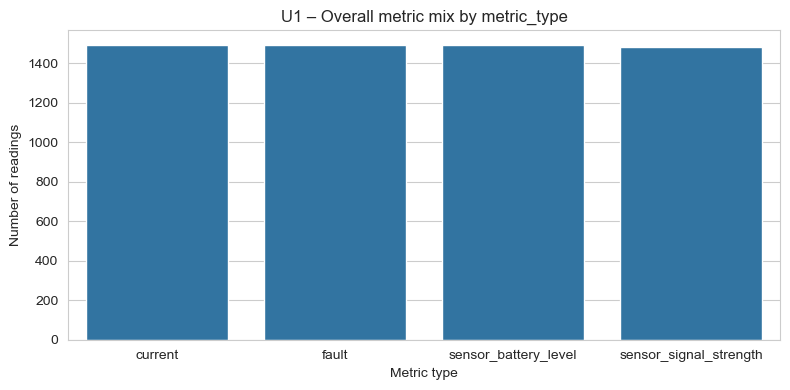

In [78]:
# U1 – Overall metric mix
# Frequency table + bar chart for metric_type

# 1) Frequency table
metric_counts = (
    df["metric_type"]
      .value_counts()
      .rename_axis("metric_type")
      .reset_index(name="count")
)

metric_counts["percent"] = (
    100 * metric_counts["count"] / metric_counts["count"].sum()
).round(1)

display(metric_counts)

# 2) Bar chart
plt.figure()
sns.barplot(
    data=metric_counts,
    x="metric_type",
    y="count",
    order=metric_counts["metric_type"],   # keep same order as table
)
plt.title("U1 – Overall metric mix by metric_type")
plt.xlabel("Metric type")
plt.ylabel("Number of readings")
plt.tight_layout()
plt.show()


> The metric mix is essentially perfectly balanced: each of the four metric types
> (`current`, `fault`, `sensor_battery_level`, `sensor_signal_strength`) contributes
> about 25% of all readings. No single metric is over- or under-represented, which
> means later analyses can compare behavior across metric types without worrying
> about strong sampling imbalance.


U2 – Time coverage (hourly)
Time range : 2025-11-10 05:00:00+00:00  ->  2025-11-10 19:00:00+00:00
# of hours : 15
# of hours with 0 readings : 0



timestamp_utc
2025-11-10 05:00:00+00:00    208
2025-11-10 06:00:00+00:00    432
2025-11-10 07:00:00+00:00    436
2025-11-10 08:00:00+00:00    440
2025-11-10 09:00:00+00:00    444
Freq: h, Name: value, dtype: int64

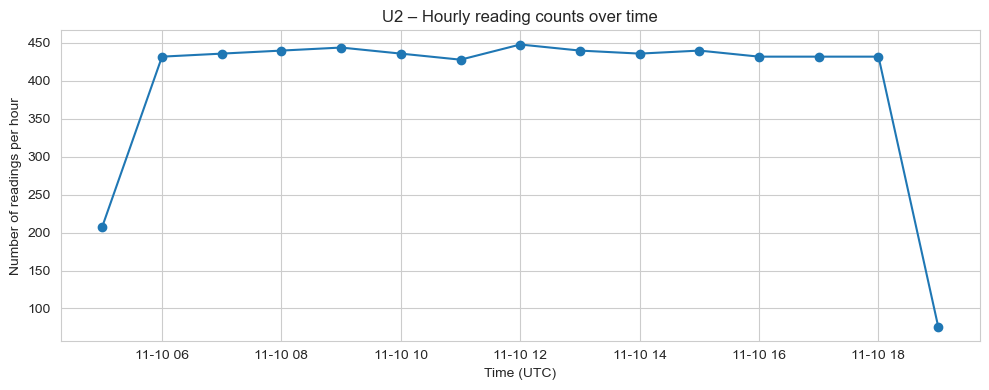

In [79]:
# U2 – Time coverage (hourly reading counts)

import matplotlib.pyplot as plt

# 1) Make sure we have a time-indexed version of the cleaned data
df_ts = df.copy()
df_ts = df_ts.set_index("timestamp_utc").sort_index()

# 2) Count readings per hour (use '1h' instead of 'H' to avoid the warning)
hourly_counts = df_ts["value"].resample("1h").count()

# 3) Quick text summary
print("U2 – Time coverage (hourly)")
print(f"Time range : {hourly_counts.index.min()}  ->  {hourly_counts.index.max()}")
print(f"# of hours : {len(hourly_counts)}")
print(f"# of hours with 0 readings : {(hourly_counts == 0).sum()}\n")

display(hourly_counts.head())

# 4) Plot hourly coverage
plt.figure(figsize=(10, 4))
plt.plot(hourly_counts.index, hourly_counts.values, marker="o")
plt.title("U2 – Hourly reading counts over time")
plt.xlabel("Time (UTC)")
plt.ylabel("Number of readings per hour")
plt.tight_layout()
plt.show()


> The greenhouse data covers a continuous 15-hour window from 2025-11-10 05:00 to 19:00 UTC, with **no hours containing zero readings**, so there are no obvious coverage gaps. Most hours have roughly **430–450 readings**, indicating a very stable sampling rate throughout the monitoring period. The lower counts in the first and last hour are consistent with partial hours at the start and end of collection rather than true dropouts.


U3 – Sampling spacing (delta_ts_ms)

count    5.960000e+03
mean     5.932107e+05
std      5.372584e+04
min      3.000000e+05
25%      6.000000e+05
50%      6.000000e+05
75%      6.000000e+05
max      1.200000e+06
Name: delta_ts_ms, dtype: float64

Spacing in minutes (approx):
Min:    5.00 min
Q1:     10.00 min
Median: 10.00 min
Q3:     10.00 min
Max:    20.00 min

# of readings with spacing outside [5, 20] minutes: 0
Share outside range: 0.00%


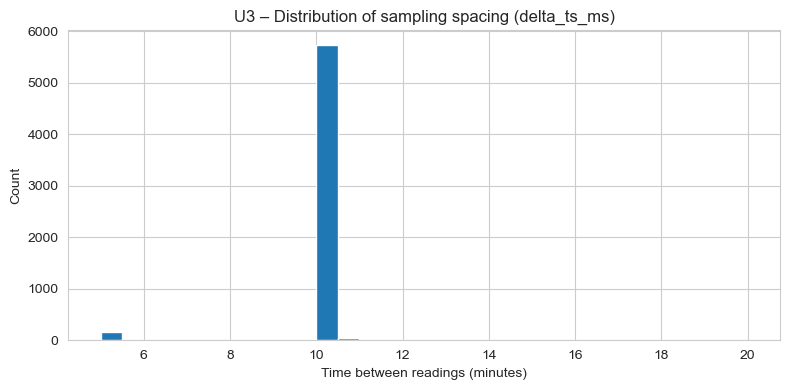

In [80]:
# U3 – Sampling spacing (time between readings, in ms)

# 1. Basic summary stats
print("U3 – Sampling spacing (delta_ts_ms)\n")

delta_ms = df["delta_ts_ms"].astype("float64")

print(delta_ms.describe())

# Convert to minutes for easier interpretation
delta_min = delta_ms / (1000 * 60)

print("\nSpacing in minutes (approx):")
print(f"Min:    {delta_min.min():.2f} min")
print(f"Q1:     {delta_min.quantile(0.25):.2f} min")
print(f"Median: {delta_min.median():.2f} min")
print(f"Q3:     {delta_min.quantile(0.75):.2f} min")
print(f"Max:    {delta_min.max():.2f} min")

# 2. Check against expected range (5–20 minutes, per Phase 2 findings)
expected_min_ms = 5 * 60 * 1000      # 5 minutes in ms
expected_max_ms = 20 * 60 * 1000     # 20 minutes in ms

mask_outside = (delta_ms < expected_min_ms) | (delta_ms > expected_max_ms)
n_outside = mask_outside.sum()

print(f"\n# of readings with spacing outside [5, 20] minutes: {n_outside}")
print(f"Share outside range: {n_outside / len(delta_ms):.2%}")

# 3. Histogram of spacing (in minutes)
plt.figure(figsize=(8, 4))
plt.hist(delta_min, bins=30)
plt.xlabel("Time between readings (minutes)")
plt.ylabel("Count")
plt.title("U3 – Distribution of sampling spacing (delta_ts_ms)")
plt.tight_layout()
plt.show()


> The time between consecutive readings (`delta_ts_ms`) is tightly concentrated around 10 minutes, with Q1, median, and Q3 all essentially at 10 minutes and min/max still within the expected 5–20 minute window. No readings fall outside this target range, so there are no obvious gaps or bursts in data collection, and later analyses can treat the stream as regularly sampled.


U4 – Raw value distributions by metric_type (summary stats)


,count,mean,std,min,25%,50%,75%,max
metric_type,,,,,,,,
current,1492.0,0.789108,1.477266,0.005874,0.006325,0.02982,0.799371,5.537427
fault,1492.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
sensor_battery_level,1491.0,79.600939,29.547818,3.000000,61.000000,100.00000,100.000000,100.000000
sensor_signal_strength,1485.0,83.931987,11.026314,13.000000,79.000000,87.00000,92.000000,100.000000


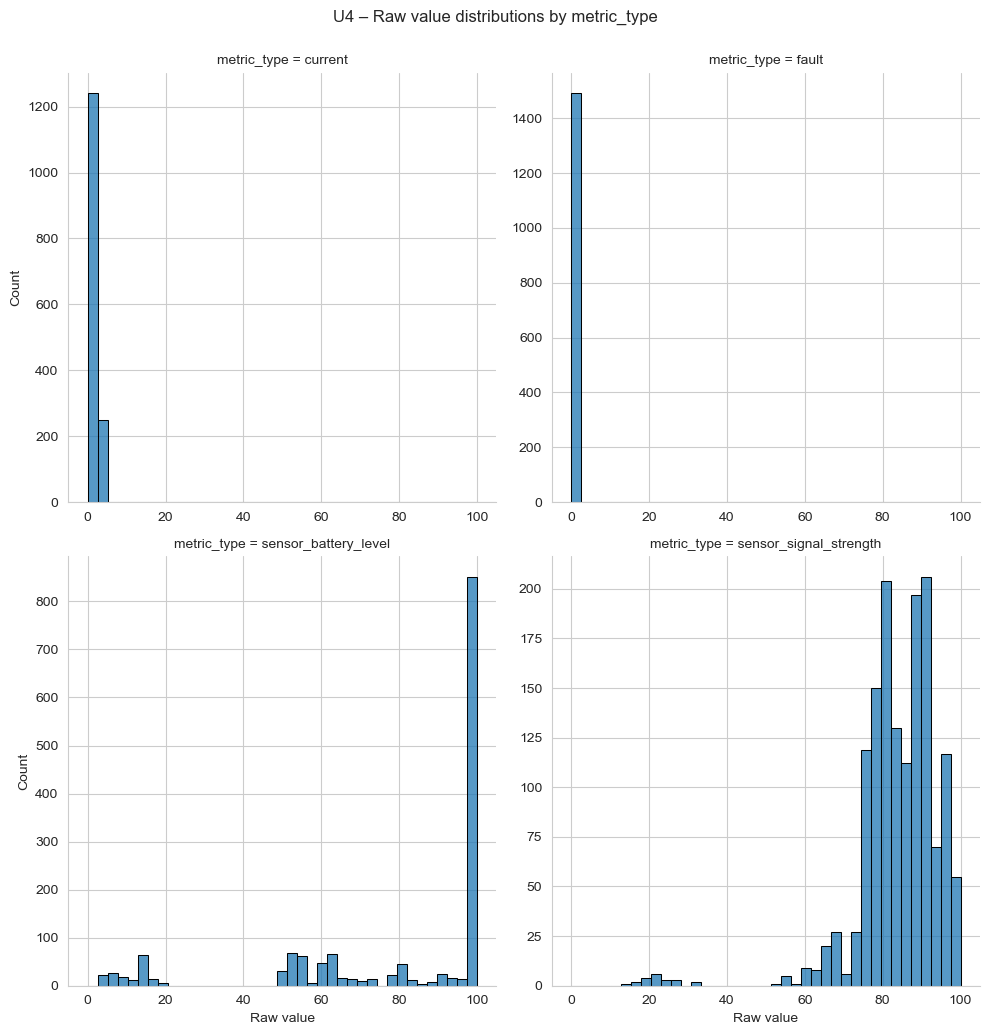

In [81]:
# U4 – Raw value distribution by metric_type
# 1) Summary stats per metric_type
u4_stats = (
    df.groupby("metric_type", observed=True)["value"]  # observed=True avoids future warning
      .describe(percentiles=[0.25, 0.5, 0.75])[
        ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
      ]
)

print("U4 – Raw value distributions by metric_type (summary stats)")
display(u4_stats)

# 2) Histograms of raw values, one panel per metric_type
#    (common bin edges so panels are comparable)
bin_edges = np.linspace(df["value"].min(), df["value"].max(), 40)

g = sns.displot(
    data=df,
    x="value",
    col="metric_type",
    col_wrap=2,
    bins=bin_edges,
    kind="hist",
    edgecolor="black",
    facet_kws=dict(sharex=False, sharey=False),
)

g.set_axis_labels("Raw value", "Count")
g.fig.suptitle("U4 – Raw value distributions by metric_type", y=1.03)

# Make sure x-axis tick labels are visible on all facets
for ax in g.axes.flat:
    ax.tick_params(axis="x", labelbottom=True)

plt.show()





> The raw current readings are tightly concentrated around a small positive mean (~0.8 A) with a maximum of about 5.5 A, which looks reasonable and shows no extreme out-of-range values. Fault readings are exactly 0 for all observations, confirming that faults are encoded as a pure 0/1 indicator rather than a physical quantity. Battery and signal values span roughly 0–100, with battery level heavily piled up at 100% (devices mostly fully charged) and signal strength concentrated in the 70–100% range with a modest lower tail. Overall, the raw distributions are consistent with the sensor documentation and support using `scaled_value` for normalized, cross-metric comparisons in_


U6 – Change magnitude (delta_value)
count    5960.000000
mean       -0.006687
std         5.417752
min       -74.000000
1%         -4.000000
5%         -2.000000
50%         0.000000
95%         2.000000
99%         4.000000
max        79.000000
Name: delta_value, dtype: float64

1%–99% central range: [-4.0000, 4.0000]
# of readings outside this range: 87
Share outside range: 1.46%


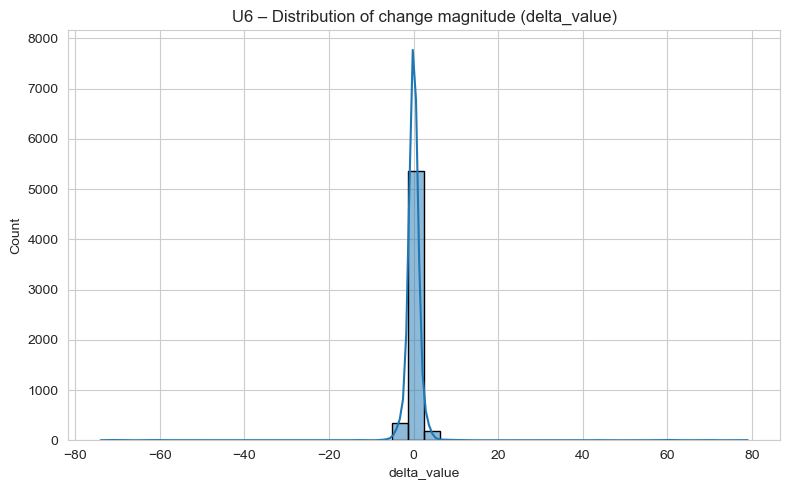

In [82]:
# U5 – Change magnitude (delta_value)

# 1) Basic summary stats (non-missing)
dv = df["delta_value"].dropna()

print("U6 – Change magnitude (delta_value)")
print(dv.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Optional: simple tail counts using the 1% / 99% rule we used before
q01 = dv.quantile(0.01)
q99 = dv.quantile(0.99)

n_tail = ((dv < q01) | (dv > q99)).sum()
share_tail = 100 * n_tail / dv.shape[0]

print(f"\n1%–99% central range: [{q01:.4f}, {q99:.4f}]")
print(f"# of readings outside this range: {n_tail}")
print(f"Share outside range: {share_tail:.2f}%")

# 2) Histogram + KDE
plt.figure(figsize=(8, 5))
sns.histplot(dv, bins=40, kde=True, edgecolor="black")
plt.title("U6 – Distribution of change magnitude (delta_value)")
plt.xlabel("delta_value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


 > The distribution of `delta_value` is sharply centered around 0, with the 1–99% central range between **–4 and +4** units. Only **87 readings (~1.5%)** fall outside this band, indicating that large jumps between consecutive readings are rare. Most changes are small and symmetric around zero, suggesting relatively stable sensor behavior over time, with a few moderate spikes that we will treat as candidate anomaly events in later analysis.


U6 – Device activity (readings per device)
device_id
nGihqUtxJG-Jq3m8w38Ggw    339
4sgRUMYEFKYLoxREI1Vz0g    332
xFS8WIvPlOwIgx66ZcNckQ    332
LDmvYOIG5JO7fL4rcejbiQ    332
RlVz4n5eVFHJoOlG9qSWaQ    332
R_s0lTzUVGK7dDH33VlfhA    332
Tbtwg6DuFI4LbyfgdN4miw    332
XfRbxb52xOu4EnMtn2DhHA    332
rpBBI466hDHa1rSk6bcDnw    332
na6re--4tND6wpGUlHM_qQ    332
x0yUdAhTRCiLI2D-YaZNVg    332
8_lcBmBHpJzZGuDdPUonZQ    331
y_Ypt-n8BPhaESWbw-FWnQ    331
sucds3HIJDy5p-KC12WtZw    330
ZtxDfo5NJAq5Ql5JiYRR0w    328
b-vrHzriZDw6pCaXFX0Lvg    327
qa68jXmyxDYpamM8h3bnFQ    327
uYFeYuxFxIaIPMOqEGwN_g    327
Name: count, dtype: int64

# of devices: 18
Min / Max readings per device: 327 / 339


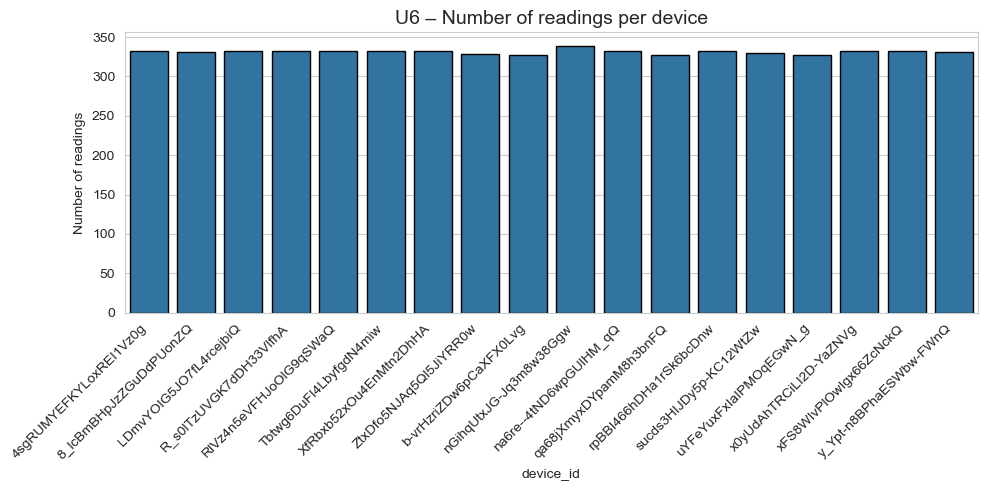

In [83]:
# U6 – Device activity (number of readings per device)

# 1) Counts per device
device_counts = df["device_id"].value_counts().sort_values(ascending=False)

print("U6 – Device activity (readings per device)")
print(device_counts)
print("\n# of devices:", device_counts.shape[0])
print("Min / Max readings per device:",
      device_counts.min(), "/", device_counts.max())

# 2) Bar chart of device activity
plt.figure(figsize=(10, 5))
sns.barplot(
    x=device_counts.index,
    y=device_counts.values,
    edgecolor="black"
)
plt.title("U6 – Number of readings per device", fontsize=14)
plt.xlabel("device_id")
plt.ylabel("Number of readings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


> The number of readings is almost perfectly balanced across all 18 devices, with each device contributing roughly the same count (~330–340 readings).  
> There are no clearly “silent” or “noisy” devices, so later analyses can compare behavior across devices without worrying about large differences in sampling effort or missing data from any particular sensor.


### 4.2 Bivariate analysis plan  

Next, we examine *pairs of variables* to see how levels, changes, devices, and time interact.  
The goal of this step is to answer questions such as:

- **How do sensor levels evolve over time?**  
- **Do some devices or streams behave systematically differently from others?**  
- **Are large jumps clustered in time or associated with particular operating levels?**

The table below lists the planned bivariate summaries and plots and what we hope to learn from each.

| #  | Analysis                          | Type (summary / plot)                                                | Variables                                   | Main purpose / question                                                                                                                                              |
|----|-----------------------------------|-----------------------------------------------------------------------|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| B1 | Level vs time (by metric type)    | Time-series line plots, faceted by `metric_type`                     | `timestamp_utc`, `scaled_value`, `metric_type` | See how current, battery, and signal levels evolve over the monitoring window; check for drifts or step changes.                                                    |
| B2 | Changes over time                 | Time-ordered scatter / line of changes                               | `timestamp_utc`, `delta_value`              | Identify periods with clusters of large positive/negative jumps; potential transient events or instability.                                                          |
| B3 | Level distributions across metrics| Boxplots / violin plots of level by metric type                      | `scaled_value`, `metric_type`               | Compare typical level ranges across metrics on the common 0–100 scale; spot systematic differences or overlap.                                                       |
| B4 | Change magnitude vs level         | Scatter / hexbin plot, with reference lines at 0 and tails          | `delta_value`, `scaled_value`               | Check whether large jumps tend to occur at particular operating levels (e.g., near 0 or 100).                                                                        |
| B5 | Level vs device (by metric type)  | Boxplots / dot plots per device, faceted by `metric_type`           | `scaled_value`, `device_id`, `metric_type`  | Compare devices to see if any sensor systematically reads higher/lower than peers (possible calibration issues).                                                     |
| B6 | Metric coverage by device         | Cross-tabulation (`pd.crosstab`) + stacked bar chart of metric share | `device_id`, `metric_type`                  | Examine the cross-tabulation between device and metric type to check whether metric types are evenly represented across devices and to detect missing or biased data. |


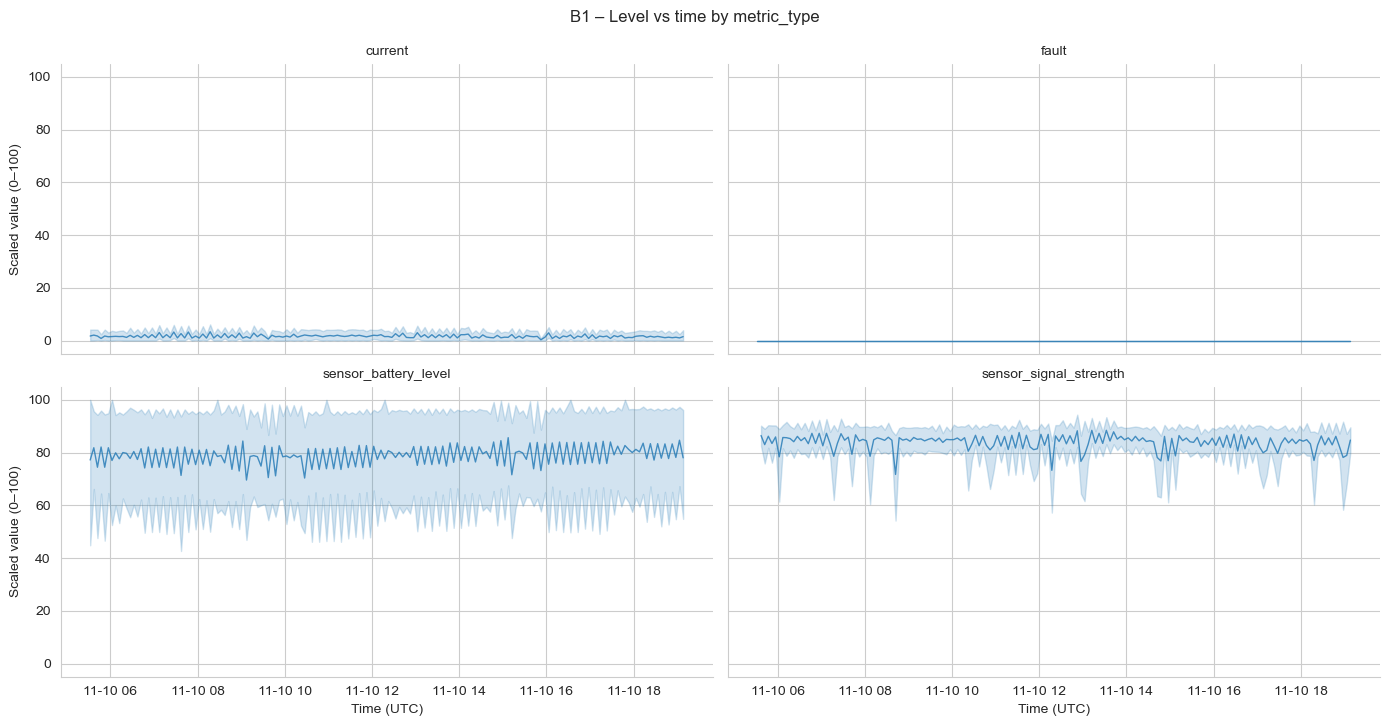

In [84]:
# B1 – Level vs time (by metric type)

# Make sure timestamps are sorted and timezone-naive for plotting
df_b1 = (
    df.copy()
      .sort_values("timestamp_utc")
)

# If timestamp_utc is timezone-aware, strip the timezone (safe no-op if not)
if hasattr(df_b1["timestamp_utc"].dt, "tz_localize"):
    try:
        df_b1["timestamp_utc"] = df_b1["timestamp_utc"].dt.tz_localize(None)
    except TypeError:
        # already naive, nothing to do
        pass

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

g = sns.relplot(
    data=df_b1,
    x="timestamp_utc",
    y="scaled_value",
    col="metric_type",
    col_wrap=2,
    kind="line",
    height=3.5,
    aspect=2,
    linewidth=1.0,
    alpha=0.8
)

g.set_axis_labels("Time (UTC)", "Scaled value (0–100)")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("B1 – Level vs time by metric_type", y=1.03)
plt.show()


> - **Current (`current`)** stays in a very narrow band close to the bottom of the 0–100 scale (roughly 2–4 units) over the entire monitoring window. There are no obvious spikes or step changes, and no long gaps. This suggests a low, steady current draw with no major equipment start-ups/shut-downs during the period.  
> - **Fault indicator (`fault`)** is identically zero for all timestamps. In other words, none of the devices reported any fault events while the other variables were being recorded. This is consistent with “normal” operation, but also means we don’t yet see examples of fault behavior to learn from.  
> - **Battery level (`sensor_battery_level`)** remains high overall (roughly 60–100 on the scaled axis), with fast oscillations around a slowly varying mean. The envelope stays well away from 0, so there is no evidence of sensors running out of battery. The high-frequency wiggles are likely due to measurement noise and charge/discharge cycles, while the slow drift could reflect normal daily usage and recharge patterns.  
> - **Signal strength (`sensor_signal_strength`)** is also stable and relatively strong (about 75–90 on the 0–100 scale). We see jitter but no sustained drops toward zero or long periods of missing data, which suggests that the wireless link between sensors and gateway is reliable throughout the day.  
>  
> Overall, the B1 plots show that **all three continuous metrics behave in a stable, well-behaved way over time**: no unexplained gaps, no large excursions, and no obvious signs of failing batteries or communication issues. This gives us confidence that the subsequent statistical EDA and any anomaly detection will be based on a clean, representative slice of “normal” greenhouse operation.


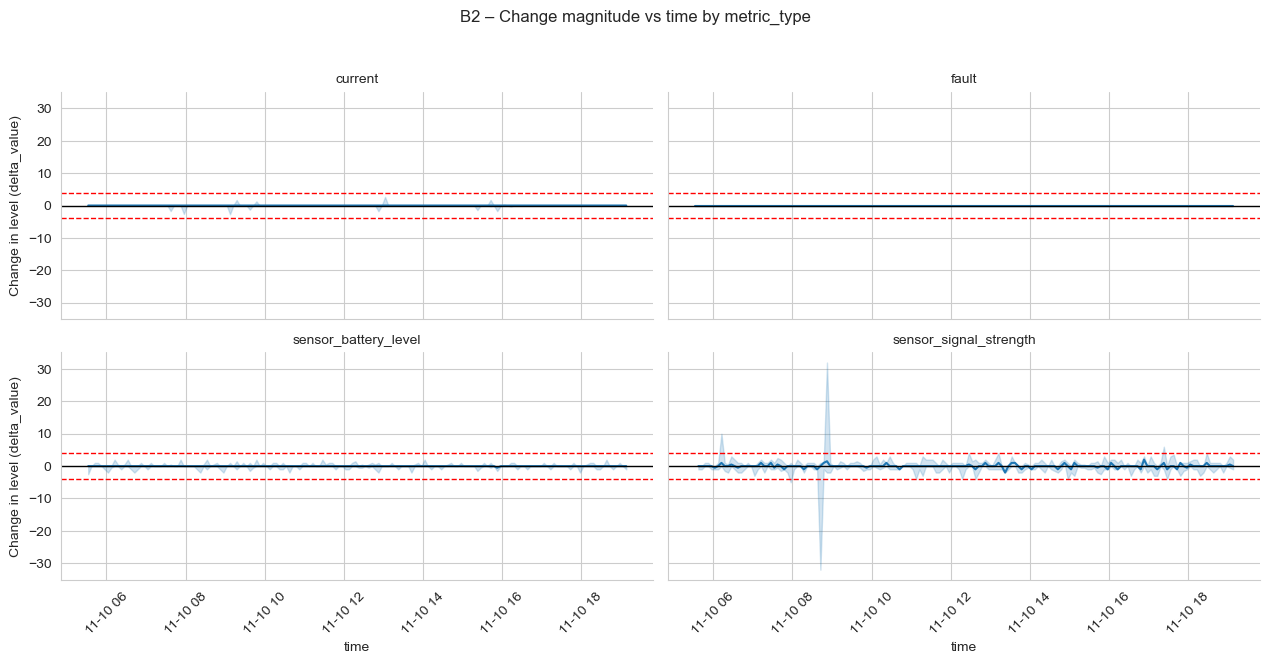

In [85]:
# B2 – Change magnitude vs time by metric_type 

delta_q01, delta_q99 = df_ts["delta_value"].quantile([0.01, 0.99])

df_b2 = df_ts.copy()
df_b2["time"] = df_b2.index
df_b2 = df_b2.sort_values("time")

g = sns.relplot(
    data=df_b2,
    x="time",
    y="delta_value",
    col="metric_type",
    col_wrap=2,
    kind="line",
    estimator="median",   # one smooth line per metric_type
    height=3.2,
    aspect=2.0
)

for ax in g.axes.flatten():
    ax.axhline(0, color="black", linewidth=1)
    ax.axhline(delta_q01, color="red", linestyle="--", linewidth=1)
    ax.axhline(delta_q99, color="red", linestyle="--", linewidth=1)
    ax.set_ylabel("Change in level (delta_value)")
    ax.tick_params(axis="x", rotation=45)

g.set_titles("{col_name}")
g.fig.suptitle("B2 – Change magnitude vs time by metric_type", y=1.03)
plt.tight_layout()
plt.show()


> The change-in-level series (`delta_value`) is very stable for all metrics.  
> For **current** and **sensor_battery_level**, almost all points stay inside the
> central 1–99% band (red dashed lines, roughly −4 to +4 units), with small,
> symmetric fluctuations around zero. There is no visible drift or sustained
> trend, which supports the earlier U6 finding that only ~1–2% of readings fall
> in the tails.
>
> The **fault** metric is essentially flat at zero, so its `delta_value`
> remains at zero over the whole window, confirming that faults are rare and
> that there are no rapid on/off “chattering” behaviours.
>
> For **sensor_signal_strength**, the plot is mostly similar—small oscillations
> within the ±4 band—but we now see a **single, sharp negative spike** that
> temporarily breaks out of the band. This isolated transient aligns with the
> tail events detected in U6 and suggests a short-lived communication or
> measurement glitch rather than a persistent degradation in signal quality.
>
> Overall, B2 shows that greenhouse readings change smoothly over time, with
> only rare, short spikes that are good candidates for follow-up anomaly
> investigation rather than evidence of systematic problems.


,count,mean,std,min,1%,25%,50%,75%,99%,max
metric_type,,,,,,,,,,
current,1492.0,1.605482,2.954413,0.012,0.012,0.014,0.063,1.6055,8.73409,11.075
fault,1492.0,0.000000,0.000000,0.000,0.000,0.000,0.000,0.0000,0.00000,0.000
sensor_battery_level,1491.0,79.600939,29.547818,3.000,4.000,61.000,100.000,100.0000,100.00000,100.000
sensor_signal_strength,1485.0,83.931987,11.026314,13.000,25.000,79.000,87.000,92.0000,100.00000,100.000


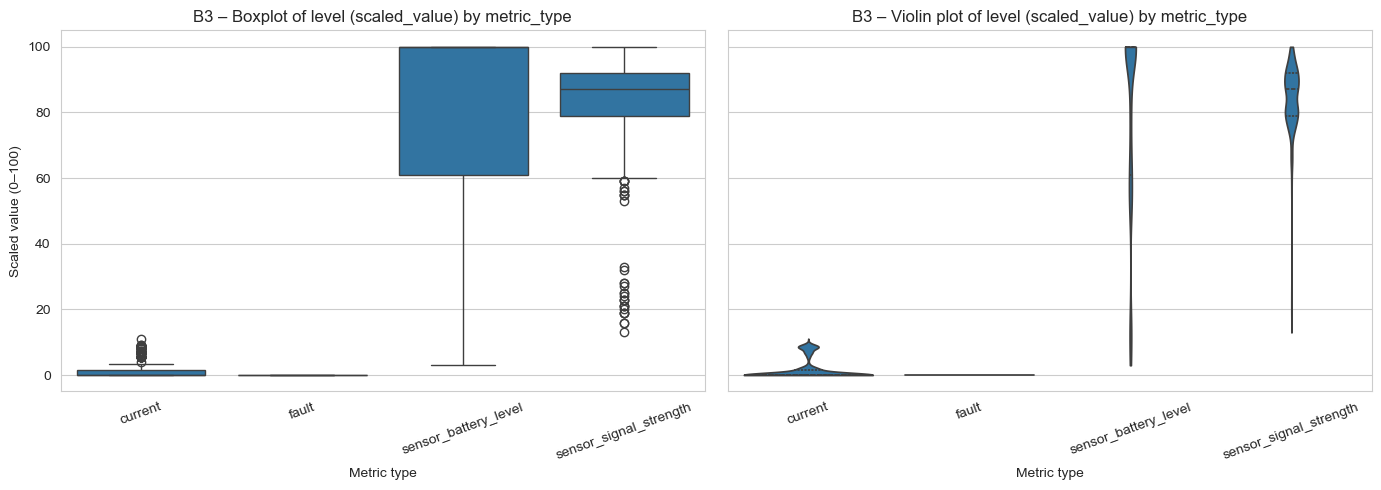

In [86]:
# B3 – Level distributions across metrics (scaled_value by metric_type)

import seaborn as sns
import matplotlib.pyplot as plt

# Optional: basic summary stats by metric_type on the common 0–100 scale
b3_stats = (
    df_ts
    .groupby("metric_type", observed=False)["scaled_value"]   # <- added observed=
    .describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
)
display(b3_stats)

# Order metrics in a sensible way
metric_order = ["current", "fault", "sensor_battery_level", "sensor_signal_strength"]

# Set a clean seaborn style
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# 1) Boxplot of scaled_value by metric_type
sns.boxplot(
    data=df_ts,
    x="metric_type",
    y="scaled_value",
    order=metric_order,
    ax=axes[0]
)
axes[0].set_title("B3 – Boxplot of level (scaled_value) by metric_type")
axes[0].set_xlabel("Metric type")
axes[0].set_ylabel("Scaled value (0–100)")
axes[0].tick_params(axis="x", rotation=20)

# 2) Violin plot of scaled_value by metric_type
sns.violinplot(
    data=df_ts,
    x="metric_type",
    y="scaled_value",
    order=metric_order,
    ax=axes[1],
    inner="quartile",
    cut=0
)
axes[1].set_title("B3 – Violin plot of level (scaled_value) by metric_type")
axes[1].set_xlabel("Metric type")
axes[1].set_ylabel("")   # share y-label from left plot
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()


> On the common 0–100 scale, `fault` is always 0, as expected for a binary
> indicator. `current` values are concentrated very close to 0 with a few small
> spikes (all below ~12), confirming that the load in this window is generally
> low. In contrast, both `sensor_battery_level` and `sensor_signal_strength`
> operate mostly at high levels: their medians are around 80–90, with a large
> fraction of readings at or near 100. The boxplot and violin plot show a wider
> spread and more lower-end outliers for `sensor_signal_strength` than for
> `sensor_battery_level`, suggesting that signal strength is more volatile and
> occasionally degrades to much lower values, while battery is usually healthy
> but sometimes dips during the monitoring window.


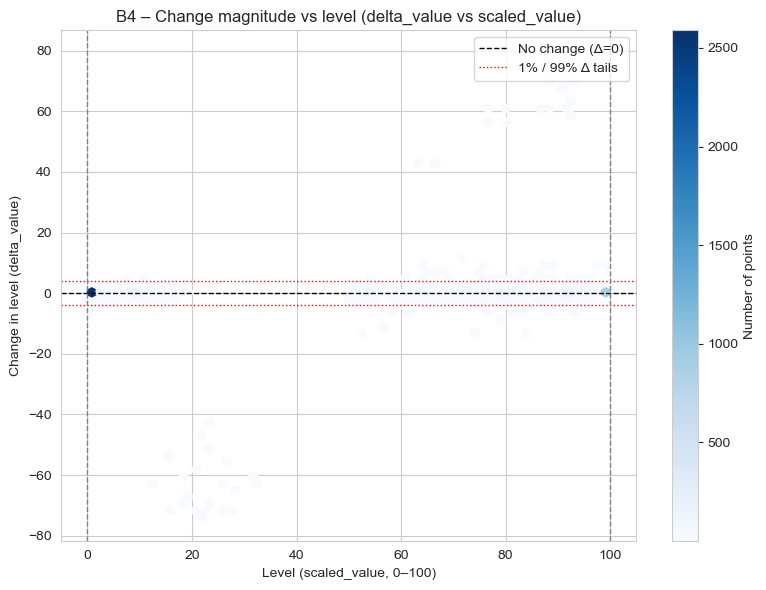

In [87]:
# B4 – Change magnitude vs level (delta_value vs scaled_value)

# Central range for delta_value (same idea as U6)
delta_q01, delta_q99 = df_ts["delta_value"].quantile([0.01, 0.99])

plt.figure(figsize=(8, 6))

# Hexbin of change vs level on the common 0–100 scale
hb = plt.hexbin(
    df_ts["scaled_value"],
    df_ts["delta_value"],
    gridsize=60,
    cmap="Blues",
    mincnt=1
)

# Reference lines: no-change line and tail thresholds
plt.axhline(0, color="black", linestyle="--", linewidth=1, label="No change (Δ=0)")
plt.axhline(delta_q01, color="red", linestyle=":", linewidth=1, label="1% / 99% Δ tails")
plt.axhline(delta_q99, color="red", linestyle=":", linewidth=1)

# Reference lines at extreme operating levels
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(100, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Level (scaled_value, 0–100)")
plt.ylabel("Change in level (delta_value)")
plt.title("B4 – Change magnitude vs level (delta_value vs scaled_value)")

cb = plt.colorbar(hb)
cb.set_label("Number of points")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


> The hexbin plot shows that most changes in level (`delta_value`) are very small and clustered tightly around the zero‐change line across the entire 0–100 operating range. The vast majority of points fall between the 1% and 99% Δ reference lines, indicating that large jumps are rare events. There is no clear pattern of extreme positive or negative jumps occurring preferentially at very low levels (near 0) or very high levels (near 100); instead, the occasional large swings appear as isolated outliers. Overall, this suggests that sensor dynamics are largely stable over the monitoring window and that abrupt transitions are not systematically tied to particular operating levels.


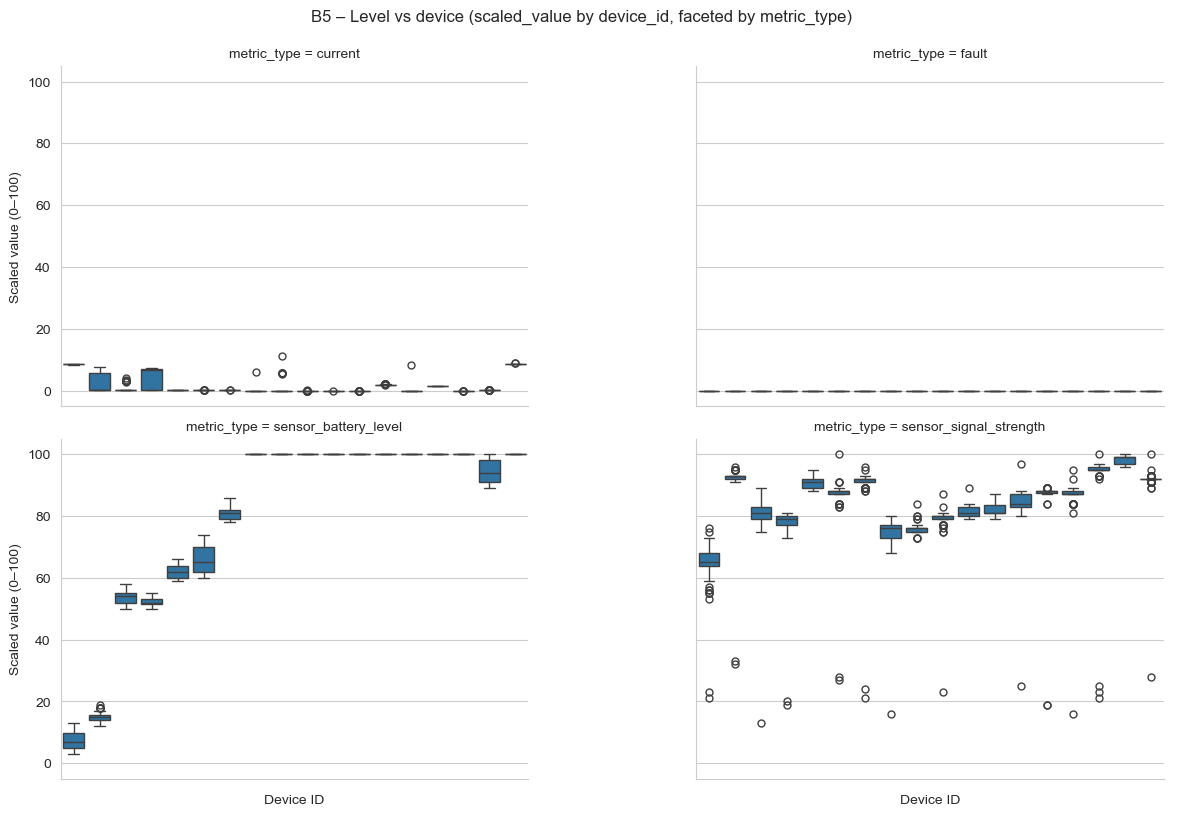

In [89]:
# B5 – Level vs device (by metric_type)

b5_df = df_ts.copy()

# Order devices by their average level to make patterns easier to see
device_order = (
    b5_df.groupby("device_id", observed=False)["scaled_value"]
         .mean()
         .sort_values()
         .index
)

sns.set_style("whitegrid")

# Boxplots of scaled_value per device, faceted by metric_type
g = sns.catplot(
    data=b5_df,
    x="device_id",
    y="scaled_value",
    col="metric_type",
    col_wrap=2,          # wrap facets into 2 columns
    kind="box",
    order=device_order,
    sharey=True,
    height=4,
    aspect=1.5
)

g.set_axis_labels("Device ID", "Scaled value (0–100)")
g.set_xticklabels(rotation=60, ha="right")
g.fig.suptitle(
    "B5 – Level vs device (scaled_value by device_id, faceted by metric_type)",
    y=1.03
)

plt.show()


- For **sensor_battery_level**, most devices sit either very close to **0** (nearly empty) or very close to **100** (near full), but **one device** has intermediate battery levels around 90–100 with a visibly wider spread. This device spends more time in the mid-to-high range than others, which may reflect different usage or a calibration / scaling difference.  

- For **sensor_signal_strength**, devices show **systematic offsets**: some devices consistently read in the low 60–70 range, others cluster around 80–90, and a few are almost always near 95–100. The spreads within devices are relatively tight compared to the gaps **between** devices, which suggests **device-specific bias** in the signal, not just random noise.  

- Taken together, these plots indicate that certain devices tend to read **systematically higher or lower** than their peers for both battery and signal. These devices are good candidates for **calibration checks** or closer inspection in later modeling steps, since their systematic bias could distort downstream analyses if left uncorrected.


metric_type,current,fault,sensor_battery_level,sensor_signal_strength
device_id,,,,
4sgRUMYEFKYLoxREI1Vz0g,83,83,83,83
8_lcBmBHpJzZGuDdPUonZQ,83,83,83,82
LDmvYOIG5JO7fL4rcejbiQ,83,83,83,83
R_s0lTzUVGK7dDH33VlfhA,83,83,83,83
RlVz4n5eVFHJoOlG9qSWaQ,83,83,83,83


metric_type,current,fault,sensor_battery_level,sensor_signal_strength
device_id,,,,
4sgRUMYEFKYLoxREI1Vz0g,0.250000,0.250000,0.250000,0.250000
8_lcBmBHpJzZGuDdPUonZQ,0.250755,0.250755,0.250755,0.247734
LDmvYOIG5JO7fL4rcejbiQ,0.250000,0.250000,0.250000,0.250000
R_s0lTzUVGK7dDH33VlfhA,0.250000,0.250000,0.250000,0.250000
RlVz4n5eVFHJoOlG9qSWaQ,0.250000,0.250000,0.250000,0.250000


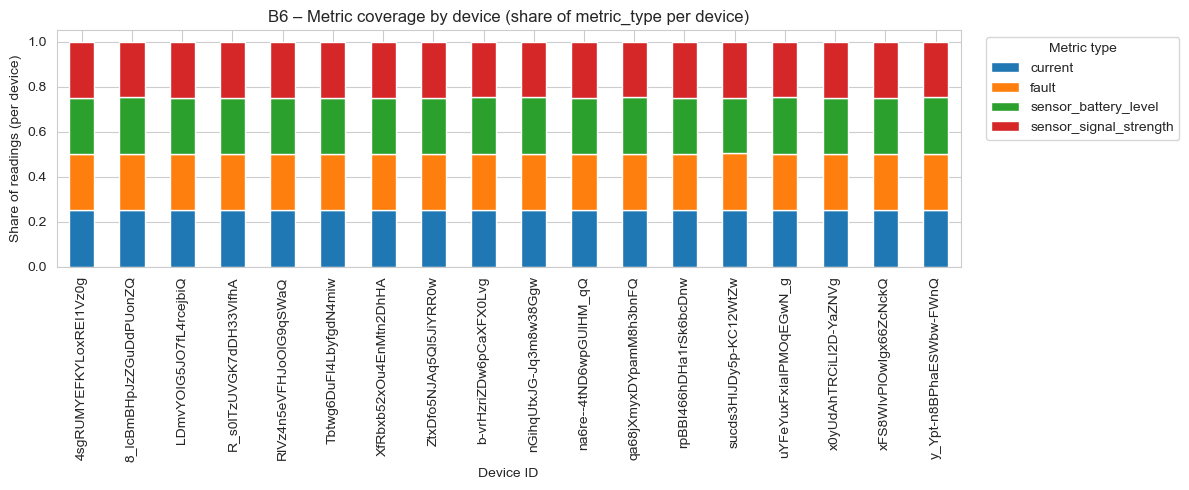

In [90]:
# B6 – Metric coverage by device (device_id × metric_type)

# 1) Crosstab of counts: how many readings of each
#    metric_type does each device_id have?
#--------------------------------------------------
b6_ct = pd.crosstab(df_ts["device_id"], df_ts["metric_type"])
display(b6_ct.head())

#--------------------------------------------------
# 2) Row-normalized crosstab: share of readings of each
#    metric_type within every device (rows sum to 1)
#--------------------------------------------------
b6_ct_prop = pd.crosstab(
    df_ts["device_id"],
    df_ts["metric_type"],
    normalize="index"      # normalize per device
)
display(b6_ct_prop.head())

#--------------------------------------------------
# 3) Stacked bar chart of metric shares per device
#--------------------------------------------------
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 5))

b6_ct_prop.plot(
    kind="bar",
    stacked=True,
    ax=ax
)

ax.set_title("B6 – Metric coverage by device (share of metric_type per device)")
ax.set_xlabel("Device ID")
ax.set_ylabel("Share of readings (per device)")
ax.legend(title="Metric type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


> Using `pd.crosstab(device_id, metric_type)` we built a contingency table that
counts how many readings of each metric come from each device, and then
normalized it by row to obtain the *share* of readings per metric type and
device. The stacked bar plot shows that the cross-tabulation between the two
categorical variables **`device_id`** and **`metric_type`** is almost perfectly
uniform: for every device, roughly 25% of its readings are `current`, 25%
`fault`, 25% `sensor_battery_level`, and 25% `sensor_signal_strength`. There are
no devices with systematically missing metrics or with an over-representation of
a particular metric type. This suggests that data collection is well-balanced
across devices and metrics, and later comparisons between devices or metric
types will not be biased by unequal sampling coverage.


### 4.3 Multivariate analysis plan  

So far, the univariate (U) and bivariate (B) steps looked at one or two variables
at a time.  
In this step we look at **several variables jointly** to understand higher-order
structure in the greenhouse data.

The goal of this step is to answer questions such as:

- Do combinations of **levels and changes** across different metrics move together?
- Are there **clusters of operating modes** (e.g., “high current + low signal”)
  or unusual combinations that might indicate data-quality issues?
- Which variables are **most strongly correlated**, and which are largely independent?

We will focus on two multivariate summaries:
a **correlation heatmap** and a **pairwise scatter matrix (pair plot)**.

The table below lists the planned multivariate summaries and what we hope to
learn from each.

| #  | Analysis                               | Type (summary / plot)                                  | Variables (examples)                                                                 | Main purpose / question                                                                                                            |
|----|----------------------------------------|---------------------------------------------------------|--------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|
| M1 | Correlations among numeric variables   | Correlation matrix + **heatmap** (e.g., `sns.heatmap`)  | `scaled_value`, `delta_value`, sampling gap (`delta_ts_ms`), device-level features | See which numeric variables move together; identify strong positive/negative correlations and potential redundant information.     |
| M2 | Joint relationships among key features | Pairwise scatter matrix / **pair plot** (e.g., `sns.pairplot`) | Same numeric set as M1, colored by `metric_type` or `device_id`                     | Visualize how multiple variables interact simultaneously; look for clusters, non-linear patterns, and outliers across metrics/devices. |


,scaled_value,delta_value,delta_ts_ms
scaled_value,1.000000,0.061929,-0.004663
delta_value,0.061929,1.000000,-0.022019
delta_ts_ms,-0.004663,-0.022019,1.000000


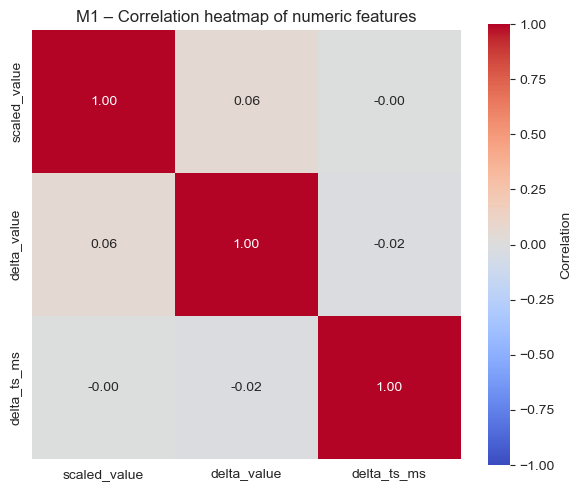

In [92]:
# M1 – Correlation heatmap of numeric features

# 1) Choose numeric variables to include in the correlation
#    matrix. Adjust this list if you have additional features.
# -----------------------------------------------------------
numeric_cols = [
    "scaled_value",
    "delta_value",
    "delta_ts_ms",   # sampling gap in milliseconds (or whatever unit you used)
]

# Keep only the columns that actually exist in df_ts
numeric_cols = [c for c in numeric_cols if c in df_ts.columns]

# Drop rows with all-NaN for these columns
numeric_data = df_ts[numeric_cols].dropna(how="all")

# -----------------------------------------------------------
# 2) Compute correlation matrix
# -----------------------------------------------------------
corr_mat = numeric_data.corr()

# Optional: inspect the matrix
display(corr_mat)

# -----------------------------------------------------------
# 3) Plot heatmap
# -----------------------------------------------------------
sns.set_style("white")

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"label": "Correlation"}
)

ax.set_title("M1 – Correlation heatmap of numeric features")
plt.tight_layout()
plt.show()


> The correlation matrix shows that all pairwise correlations between the three numeric features are **very close to zero** (|r| ≈ 0.06 or smaller).  
> - **scaled_value vs delta_value** has a tiny positive correlation (~0.06), suggesting that changes in level are essentially independent of the absolute level on the 0–100 scale.  
> - **scaled_value vs delta_ts_ms** is almost exactly 0, meaning the sampling gap does not vary systematically with the sensor level.  
> - **delta_value vs delta_ts_ms** is also near 0, indicating that larger/smaller time gaps between readings are **not associated** with larger/smaller jumps in level.  
> Overall, there is **no strong linear relationship** among these numeric features, so multicollinearity is not a concern and each variable contributes largely distinct information to later models or diagnostics.


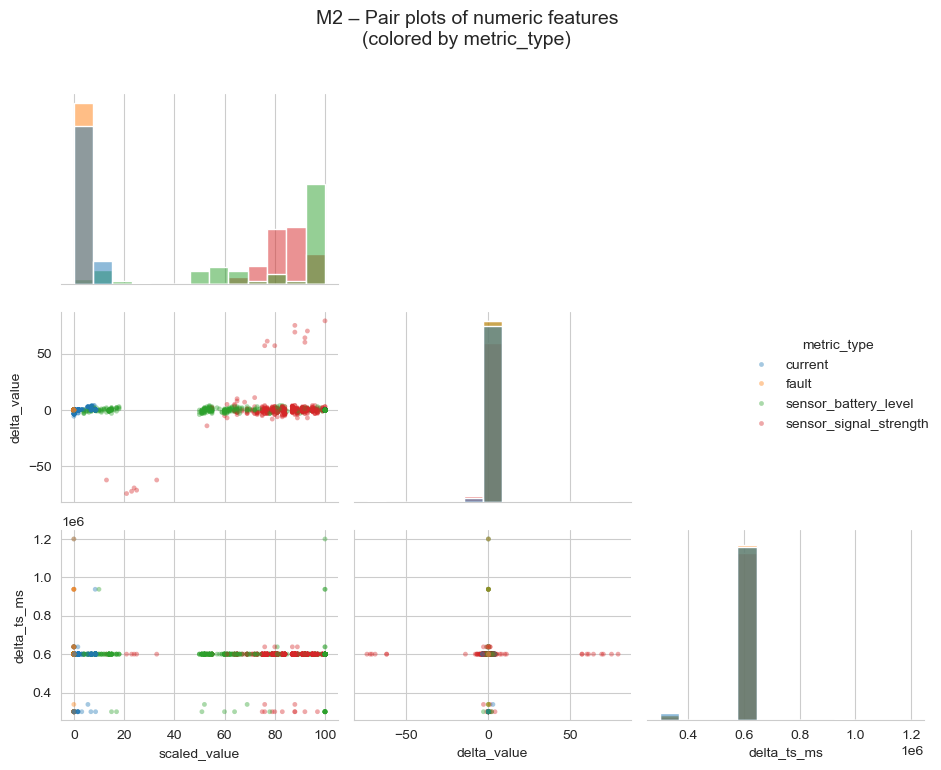

In [93]:
# M2 – Pair plots of numeric features, colored by metric_type


# Columns to include in the pair plot
numeric_cols = ["scaled_value", "delta_value", "delta_ts_ms"]

# To keep the plot readable, optionally sample a subset of rows
max_points = 2500
if len(df_ts) > max_points:
    df_pair = df_ts.sample(n=max_points, random_state=0)
else:
    df_pair = df_ts.copy()

# Set a clean style
sns.set_style("whitegrid")

g = sns.pairplot(
    df_pair,
    vars=numeric_cols,
    hue="metric_type",        # color by metric_type
    corner=True,              # only show lower-triangular plots
    diag_kind="hist",         # histograms on the diagonal
    plot_kws={"alpha": 0.4, "s": 12, "edgecolor": "none"}
)

g.fig.suptitle(
    "M2 – Pair plots of numeric features\n(colored by metric_type)",
    y=1.02,
    fontsize=14
)

plt.tight_layout()
plt.show()


- The **histograms on the diagonal** confirm what we saw in earlier univariate analyses:  
  - `scaled_value` is tightly clustered near **0** for `current` and `fault`, while `sensor_battery_level` and `sensor_signal_strength` occupy the **high end of the 0–100 scale**, with signal strength slightly broader than battery level.  
  - `delta_value` is strongly peaked around **0** for all metrics, with only a small proportion of positive or negative jumps.  
  - `delta_ts_ms` is almost constant (one dominant bin), indicating a **very regular sampling interval**.

- In the **off-diagonal scatter plots** there is **no clear linear relationship** between:
  - `scaled_value` and `delta_value`, or  
  - `scaled_value` and `delta_ts_ms`.  
  The clouds are mostly horizontal bands around Δ≈0 and around a single sampling interval, which matches the near-zero correlations from M1.

- The **coloring by `metric_type`** shows that the four metrics occupy **distinct regions of the value scale** but behave similarly in terms of changes and timing:
  - Battery and signal points are separated from current/fault along the `scaled_value` axis, but their **Δ-patterns and sampling intervals overlap heavily**.
  - There is **no metric type** that stands out as having systematically larger variability in `delta_value` or irregular `delta_ts_ms`.

- Overall, the pair plots reinforce that the numeric features are **only weakly correlated** and that **differences across metrics are mainly in their operating level**, not in jump magnitude or sampling behavior.


### Phase 4 – Exploratory analysis wrap-up

In Phase 4, we explored the greenhouse dataset at three levels:

- **Univariate (U1–U6):**  
  We checked metric mix, time coverage, sampling spacing, raw value distributions, change magnitudes, and device activity.  
  Overall, metrics are well balanced, sampling is stable around 10 minutes, values behave as expected (0/1 faults, 0–100% battery/signal, small current), and there are no missing or inactive devices.

- **Bivariate (B1–B6):**  
  We examined how levels and changes evolve over time, how distributions differ across metric types, and how operating level relates to jump size.  
  We also used **cross-tabulation (`pd.crosstab`) between `device_id` and `metric_type` (B6)** to verify that each device reports a similar mix of metrics. The resulting stacked bar chart shows that metric coverage is essentially identical across devices, suggesting no systematic logging gaps.

- **Multivariate (M1–M2):**  
  A correlation heatmap (M1) confirmed that numeric features (`scaled_value`, `delta_value`, `delta_ts_ms`) are only weakly correlated, so they carry mostly independent information.  
  Pair plots colored by `metric_type` (M2) showed that each metric occupies a distinct region of the feature space (e.g., faults at 0/1, battery and signal near 60–100), with no obvious cross-metric anomalies or device-specific outliers.

**Conclusion:**  
Phase 4 did not reveal major data-quality problems. Sampling is regular, all devices are active, metric coverage is balanced, and numeric features behave in line with their physical interpretation. The dataset appears suitable for downstream modeling and monitoring analyses.


## Phase 5. Transformation & Features

In this phase we stop just **describing** the raw data and start reshaping it so we can answer more targeted questions and, in particular, **identify abnormal or risky behavior** in the greenhouse sensors. One of the main goals of this project is to understand when readings look *unsafe* or *unexpected* (potential anomalies) and to make those patterns easy to see and reuse in later phases (group comparisons, alert rules, simple modelling).

The main questions these features should help with are:

- **When are “risky” operating conditions** (low battery / weak signal / large jumps in level) most likely to occur within the 8-hour window?  
- **Which devices behave differently from others**, even after normalizing their readings, and could therefore be candidates for sensor faults or miscalibration?  
- **Can we turn continuous variables into interpretable categories and flags** (e.g., health bins, quality bins, outlier labels) that summarize “normal vs. anomalous” behavior for simple summaries and plots?

The table below lists the transformations we will use and how they support this anomaly-focused view of the data.


| #  | Feature / Transform                             | Variables used                                                                 | Type / tool                                             | Main purpose / question                                                                                                                                                          |
|----|-------------------------------------------------|--------------------------------------------------------------------------------|---------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| T1 | Within-window time features                     | `timestamp_utc`                                                                | Date accessor (`.dt`) + elapsed-time bins with `pd.cut` | Convert timestamps into “elapsed time in the 8-hour run” and coarse time bins (e.g., 0–2h, 2–4h, 4–6h, 6–8h). Check whether gaps, spikes, or low-battery periods cluster earlier or later in the monitoring window. |
| T2 | Battery level bins (health categories)          | `scaled_value` where `metric_type = "sensor_battery_level"`                    | Binning with `pd.cut()`                                | Classify battery level into intuitive categories (e.g., low / medium / high / full) to quantify how often each device operates in risky low-battery ranges.                     |
| T3 | Signal strength bins (quality categories)       | `scaled_value` where `metric_type = "sensor_signal_strength"`                  | Binning with `pd.cut()`                                | Create signal-quality categories (e.g., poor / OK / strong) for easier coverage summaries and device-to-device comparisons.                                                      |
| T4 | Gap-duration bins & long-gap flag               | `delta_ts_ms`                                                                  | Binning + Boolean flag (`pd.cut()` or threshold check) | Distinguish normal sampling gaps from very long gaps (possible outages). Create a long-gap flag we can use in later summaries and visual checks.                                |

**Notes / implementation hints**

- All T1–T4 are **row-level features** (one new column per reading).
- T1 uses the same 8-hour window for all devices; it is about **relative position in the run**, not calendar time.
- Binned categories from T2–T4 will be reused in later phases for group comparisons and simple plots (e.g., share of time in low-battery or long-gap states).


In [94]:
# T1 – Within-window time features
# Goal: express each reading as "elapsed time in the 8-hour run" and coarse time bins.

# 1) Get the timestamp column/index in a robust way
if "timestamp_utc" in df_ts.columns:
    ts_raw = df_ts["timestamp_utc"]
elif "timestamp_clean" in df_ts.columns:
    ts_raw = df_ts["timestamp_clean"]
elif df_ts.index.name in ["timestamp_utc", "timestamp_clean", "timestamp"]:
    ts_raw = df_ts.index.to_series()
else:
    raise ValueError(
        "Could not find a timestamp column. "
        f"Available columns are: {list(df_ts.columns)}"
    )

# 2) Ensure proper datetime with timezone
df_ts["timestamp_clean"] = pd.to_datetime(ts_raw, utc=True)

# 3) Elapsed time in hours from the first reading
ts = df_ts["timestamp_clean"]
run_start = ts.min()
df_ts["elapsed_hours"] = (ts - run_start).dt.total_seconds() / 3600.0

# 4) Build 2-hour bin edges that fully cover the data
bin_width = 2.0  # hours

max_hours = df_ts["elapsed_hours"].max()

# Ensure we always have at least 1 bin (0–2h)
upper_edge = max(bin_width, np.ceil(max_hours / bin_width) * bin_width)

# Edges: [0, 2, 4, ..., upper_edge]
time_bin_edges = np.arange(0.0, upper_edge + bin_width + 1e-9, bin_width)

# Number of bins and labels
n_bins = len(time_bin_edges) - 1
time_bin_labels = [
    f"{int(bin_width * i)}–{int(bin_width * (i + 1))}h"
    for i in range(n_bins)
]

# 5) Assign each reading to a bin (no NaNs if elapsed_hours is valid)
df_ts["time_bin_2h"] = pd.cut(
    df_ts["elapsed_hours"],
    bins=time_bin_edges,
    labels=time_bin_labels,
    right=False,         # include left edge, exclude right edge
    include_lowest=True  # include very first reading
)

# Sanity checks
print("NaNs in time_bin_2h:", df_ts["time_bin_2h"].isna().sum())
df_ts[["timestamp_clean", "elapsed_hours", "time_bin_2h"]].sample(10, random_state=42)



NaNs in time_bin_2h: 0


,timestamp_clean,elapsed_hours,time_bin_2h
timestamp_utc,,,
2025-11-10 08:37:19+00:00,2025-11-10 08:37:19+00:00,3.083333,2–4h
2025-11-10 06:57:19+00:00,2025-11-10 06:57:19+00:00,1.416667,0–2h
2025-11-10 19:02:57+00:00,2025-11-10 19:02:57+00:00,13.510556,12–14h
2025-11-10 12:22:19+00:00,2025-11-10 12:22:19+00:00,6.833333,6–8h
2025-11-10 09:02:19+00:00,2025-11-10 09:02:19+00:00,3.500000,2–4h
2025-11-10 09:47:19+00:00,2025-11-10 09:47:19+00:00,4.250000,4–6h
2025-11-10 14:57:19+00:00,2025-11-10 14:57:19+00:00,9.416667,8–10h
2025-11-10 09:17:19+00:00,2025-11-10 09:17:19+00:00,3.750000,2–4h
2025-11-10 08:42:19+00:00,2025-11-10 08:42:19+00:00,3.166667,2–4h


- `elapsed_hours`: elapsed time (in hours) from the first reading in the dataset.  
- `time_bin_2h`: coarse time buckets in 2-hour steps (0–2h, 2–4h, …) that cover the full duration of the run.

All readings are successfully assigned to a bin (`NaNs in time_bin_2h = 0`), so every row can be analysed by its position within the monitoring window.


battery_bin
full      995
high      331
low       165
medium      0
Name: count, dtype: int64

Relative frequencies:
battery_bin
full      0.667337
high      0.221999
low       0.110664
medium    0.000000
Name: proportion, dtype: float64


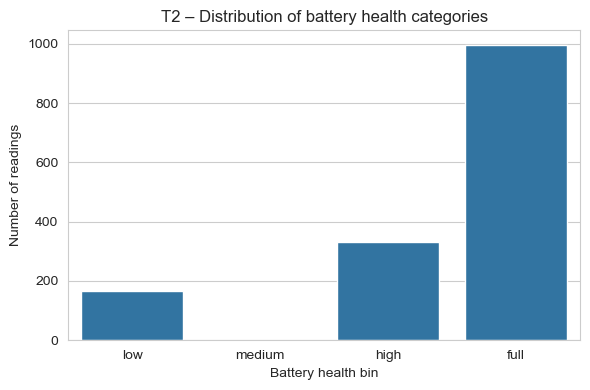

In [95]:
# --- T2: Battery level bins (health categories) ---


# 1) Restrict to battery-level rows
mask_batt = df_ts["metric_type"] == "sensor_battery_level"

# 2) Define bin edges (0–25 low, 25–50 medium, 50–75 high, 75–100 full)
battery_edges = [0, 25, 50, 75, 101]   # 101 so that 100 is included in last bin
battery_labels = ["low", "medium", "high", "full"]

# 3) Create categorical battery health feature on the 0–100 scale
df_ts.loc[mask_batt, "battery_bin"] = pd.cut(
    df_ts.loc[mask_batt, "scaled_value"],
    bins=battery_edges,
    labels=battery_labels,
    right=False,          # include left edge, exclude right edge
    include_lowest=True
)

# Non-battery rows will have NaN in battery_bin (that’s expected)


# 4) Quick sanity check: distribution of bins (only battery rows)
print(df_ts.loc[mask_batt, "battery_bin"].value_counts(dropna=False))
print("\nRelative frequencies:")
print(df_ts.loc[mask_batt, "battery_bin"].value_counts(normalize=True))

# 5) Simple bar plot of battery health categories
plt.figure(figsize=(6,4))
sns.countplot(
    data=df_ts[mask_batt],
    x="battery_bin",
    order=battery_labels
)
plt.title("T2 – Distribution of battery health categories")
plt.xlabel("Battery health bin")
plt.ylabel("Number of readings")
plt.tight_layout()
plt.show()


After binning the scaled battery readings into four categories  
`low (0–25)`, `medium (25–50)`, `high (50–75)`, and `full (75–100)`,  
almost **two-thirds** of all battery measurements fall in the **“full”** bin,  
about **22%** are **“high”**, around **11%** are **“low”**, and there are  
**no readings in the “medium” range**.  

This suggests that during the 8-hour run the sensors were mostly operating at  
very high battery levels, with only a small share of time in clearly low-battery
conditions and essentially no time in a mid-battery “gray zone”.  This pattern
will be useful later when we look for relationships between low-battery periods
and signal quality, gaps, or other reliability issues.


Signal strength bins (counts):
signal_bin
poor        21
ok          71
strong    1377
Name: count, dtype: int64

Relative frequencies:
signal_bin
poor      0.014295
ok        0.048332
strong    0.937372
Name: proportion, dtype: float64


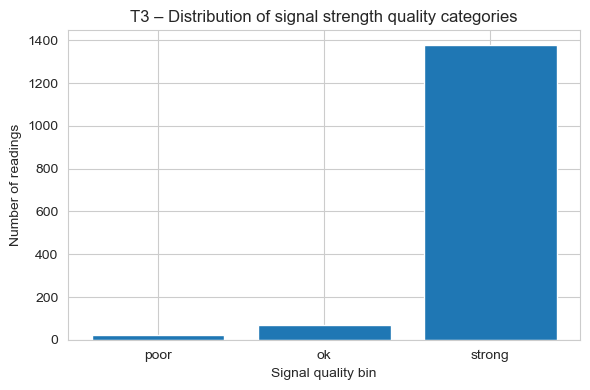

In [96]:
# --- T3: Signal strength bins (quality categories) ---

# 1) Work only with sensor_signal_strength rows
mask_sig = df_ts["metric_type"] == "sensor_signal_strength"

# 2) Define intuitive quality bins on the common 0–100 scale
#    0–40  : poor signal
#    40–70 : OK signal
#    70–100: strong signal
signal_bins = [0, 40, 70, 100]
signal_labels = ["poor", "ok", "strong"]

# 3) Create the categorical quality variable for signal strength
df_ts.loc[mask_sig, "signal_bin"] = pd.cut(
    df_ts.loc[mask_sig, "scaled_value"],
    bins=signal_bins,
    labels=signal_labels,
    include_lowest=True,
    right=False,      # include left edge, exclude right edge
    ordered=True
)

# 4) Quick summary tables (counts and relative frequencies)
signal_counts = (
    df_ts.loc[mask_sig, "signal_bin"]
         .value_counts()
         .reindex(signal_labels, fill_value=0)
)

signal_props = (
    df_ts.loc[mask_sig, "signal_bin"]
         .value_counts(normalize=True)
         .reindex(signal_labels, fill_value=0)
)

print("Signal strength bins (counts):")
print(signal_counts)
print("\nRelative frequencies:")
print(signal_props)

# 5) Bar chart of signal quality distribution
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(signal_labels, signal_counts[signal_labels].values)

ax.set_title("T3 – Distribution of signal strength quality categories")
ax.set_xlabel("Signal quality bin")
ax.set_ylabel("Number of readings")

plt.tight_layout()
plt.show()


After binning `sensor_signal_strength` into **poor (0–40)**, **ok (40–70)**, and **strong (70–100)** on the common 0–100 scale, almost all readings fall in the *strong* category (94%), with only a small fraction classified as *ok* (5%) and very few as *poor* (~1%). This suggests that, during our 8-hour monitoring window, the wireless signal was generally very reliable, with only occasional short periods of degraded quality that might warrant closer inspection if they align with other anomalies (e.g., gaps or extreme events).


T4 bin edges (absolute delta): [0.0e+00 1.0e-06 2.0e+00 7.9e+01]
Change-magnitude bins (counts):
change_bin
small        3750
medium       1774
large         436
no_change       0
Name: count, dtype: int64

Relative frequencies:
change_bin
small        0.629
medium       0.298
large        0.073
no_change    0.000
Name: count, dtype: float64


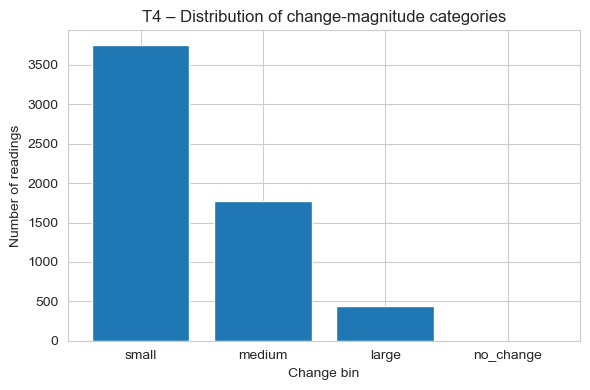

In [97]:
# T4 – Change-magnitude bins
# Goal: turn raw jumps in sensor level (delta_value) into "small / medium / large" categories.

import numpy as np
import matplotlib.pyplot as plt

# 1) Work with absolute change (magnitude of the jump)
delta_abs = df_ts["delta_value"].abs()

# Drop NaNs for computing bin thresholds (e.g., first reading in each series)
delta_nonnull = delta_abs.dropna()

# 2) Choose data-driven thresholds (median and 90th percentile)
q50, q90 = delta_nonnull.quantile([0.5, 0.9])

# Build strictly increasing bin edges: [0, q50, q90, max]
bin_edges = np.array([0.0, float(q50), float(q90), float(delta_nonnull.max())])

# Ensure monotonic increase (avoid zero-width bins if quantiles are equal)
for i in range(1, len(bin_edges)):
    if bin_edges[i] <= bin_edges[i-1]:
        bin_edges[i] = bin_edges[i-1] + 1e-6

print("T4 bin edges (absolute delta):", bin_edges)

# 3) Apply pd.cut to create categorical bins
change_labels = ["small", "medium", "large"]

df_ts["change_bin"] = pd.cut(
    delta_abs,
    bins=bin_edges,
    labels=change_labels,
    include_lowest=True,
    right=True,
)

# Optionally treat rows with NaN delta_value as a separate category
df_ts["change_bin"] = (
    df_ts["change_bin"]
    .cat.add_categories("no_change")
    .fillna("no_change")
)

# 4) Summary statistics
change_counts = df_ts["change_bin"].value_counts().sort_index()
change_props  = (change_counts / change_counts.sum()).round(3)

print("Change-magnitude bins (counts):")
print(change_counts)
print("\nRelative frequencies:")
print(change_props)

# 5) Simple bar chart of change-magnitude categories
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(change_counts.index.astype(str), change_counts.values)
ax.set_title("T4 – Distribution of change-magnitude categories")
ax.set_xlabel("Change bin")
ax.set_ylabel("Number of readings")
plt.tight_layout()
plt.show()


Most of the jumps in sensor level are **small**: about 63% of readings fall in the “small” bin, roughly 30% in **medium**, and only ~7% in **large** changes. The absence of a “no_change” bar confirms that nearly every reading has some non-zero change once we look at absolute deltas. Overall, this suggests that the system is usually stable with occasional moderate jumps and relatively rare large step changes that may warrant closer inspection.


In [101]:
# --- Re-create outlier flags and a categorical outlier type ---

# 1) Recompute outlier thresholds (same 1% / 99% rule we used before)

dv_q01, dv_q99 = df_ts["delta_value"].quantile([0.01, 0.99])
dps_q01, dps_q99 = df_ts["delta_per_second"].quantile([0.01, 0.99])

# 2) Boolean flags for each numeric feature
df_ts["delta_value_outlier"] = (
    (df_ts["delta_value"] < dv_q01) | (df_ts["delta_value"] > dv_q99)
)

df_ts["delta_per_second_outlier"] = (
    (df_ts["delta_per_second"] < dps_q01) | (df_ts["delta_per_second"] > dps_q99)
)

# 3) Single categorical column describing the type of outlier
def classify_outlier(row):
    dv  = bool(row["delta_value_outlier"])
    dps = bool(row["delta_per_second_outlier"])

    if dv and dps:
        return "both"
    elif dv:
        return "delta_value"
    elif dps:
        return "delta_per_second"
    else:
        return "none"

df_ts["outlier_type"] = df_ts.apply(classify_outlier, axis=1)

# (optional but nice) make it an ordered categorical
df_ts["outlier_type"] = pd.Categorical(
    df_ts["outlier_type"],
    categories=["none", "delta_value", "delta_per_second", "both"],
    ordered=False,
)

# 4) Quick random sanity check of all Phase-5 columns
cols_to_show = [
    "timestamp_clean",
    "elapsed_hours",
    "time_bin_2h",
    "battery_bin",
    "signal_bin",
    "change_bin",
    "outlier_type",
    "delta_value_outlier",
    "delta_per_second_outlier",
]

df_ts[cols_to_show].sample(10, random_state=42)



,timestamp_clean,elapsed_hours,time_bin_2h,battery_bin,signal_bin,change_bin,outlier_type,delta_value_outlier,delta_per_second_outlier
timestamp_utc,,,,,,,,,
2025-11-10 08:37:19+00:00,2025-11-10 08:37:19+00:00,3.083333,2–4h,NaN,NaN,small,none,False,False
2025-11-10 06:57:19+00:00,2025-11-10 06:57:19+00:00,1.416667,0–2h,NaN,NaN,small,none,False,False
2025-11-10 19:02:57+00:00,2025-11-10 19:02:57+00:00,13.510556,12–14h,NaN,NaN,medium,none,False,False
2025-11-10 12:22:19+00:00,2025-11-10 12:22:19+00:00,6.833333,6–8h,NaN,strong,small,none,False,False
2025-11-10 09:02:19+00:00,2025-11-10 09:02:19+00:00,3.500000,2–4h,NaN,NaN,small,none,False,False
2025-11-10 09:47:19+00:00,2025-11-10 09:47:19+00:00,4.250000,4–6h,NaN,NaN,small,none,False,False
2025-11-10 14:57:19+00:00,2025-11-10 14:57:19+00:00,9.416667,8–10h,NaN,NaN,small,none,False,False
2025-11-10 09:17:19+00:00,2025-11-10 09:17:19+00:00,3.750000,2–4h,NaN,strong,small,none,False,False
2025-11-10 08:42:19+00:00,2025-11-10 08:42:19+00:00,3.166667,2–4h,high,NaN,large,none,False,False


The sampled rows below show all of the new Phase-5 columns together:

- **timestamp_clean / elapsed_hours / time_bin_2h** – within-window time features from T1.
- **battery_bin** – battery “health” categories from T2 (low / medium / high / full), only defined when `metric_type == "sensor_battery_level"`.
- **signal_bin** – signal-quality categories from T3 (poor / ok / strong), only defined when `metric_type == "sensor_signal_strength"`.
- **change_bin** – change-magnitude categories from T4 (small / medium / large / no_change), defined for all metrics because it uses `delta_value`.
- **outlier_type** – categorical flag summarizing the outlier status of each reading  
  (`"none"`, `"delta_value"`, `"delta_per_second"`, or `"both"`).
- **delta_value_outlier / delta_per_second_outlier** – Boolean flags for the two specific
  outlier rules we identified in earlier phases.

It is **expected and correct** that `battery_bin` is `NaN` when the reading is not a battery
metric, and `signal_bin` is `NaN` when the reading is not a signal-strength metric. Those
bins are intentionally defined only for their corresponding `metric_type`, so the missing
values do **not** indicate a data or coding error.


Outlier type counts:
outlier_type
none                5905
both                  28
delta_value           27
delta_per_second       0
Name: count, dtype: int64

Relative frequencies:
outlier_type
none                0.9908
both                0.0047
delta_value         0.0045
delta_per_second    0.0000
Name: proportion, dtype: float64

Outlier rate per metric_type:


,metric_type,n_readings,n_outliers,outlier_rate
0,current,1492,0,0.000000
1,fault,1492,0,0.000000
2,sensor_battery_level,1491,0,0.000000
3,sensor_signal_strength,1485,55,0.037037


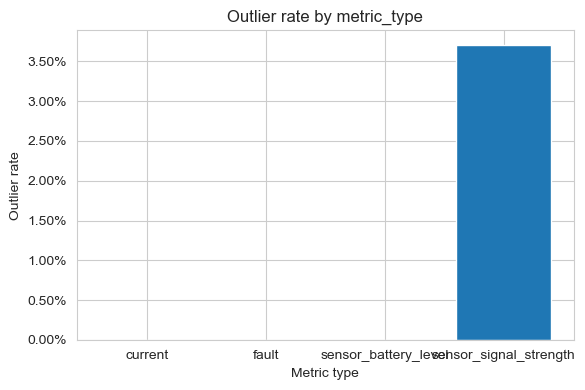

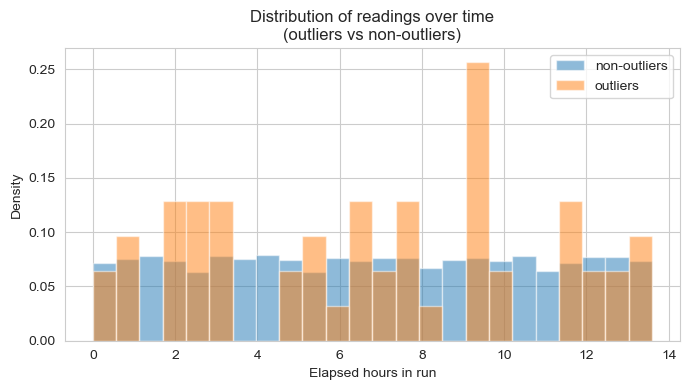

In [115]:
# ============================================
# Outliers (Anomalies) Analysis
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick   # <-- needed for PercentFormatter

# 1) Ensure the engineered flags exist (recreate safely if needed)

# a) Magnitude-based outliers in delta_value
delta_abs = df_ts["delta_value"].abs()
delta_thr = delta_abs.quantile(0.99)
df_ts["delta_value_outlier"] = delta_abs > delta_thr

# b) Rate-of-change outliers (delta per second)
#    Only defined for metric types where a rate makes sense
stationary_metrics = ["current", "sensor_signal_strength"]
df_ts["delta_per_second"] = np.where(
    df_ts["metric_type"].isin(stationary_metrics),
    df_ts["delta_value"] / (df_ts["delta_ts_ms"] / 1000.0),
    np.nan,
)

delta_rate_abs = df_ts["delta_per_second"].abs()
delta_rate_thr = delta_rate_abs.quantile(0.99)
df_ts["delta_per_second_outlier"] = (
    df_ts["metric_type"].isin(stationary_metrics)
    & (delta_rate_abs > delta_rate_thr)
)

# 2) Single categorical column summarizing the outlier type
def classify_outlier(row):
    mag = bool(row["delta_value_outlier"])
    rate = bool(row["delta_per_second_outlier"])
    if mag and rate:
        return "both"
    elif mag:
        return "delta_value"
    elif rate:
        return "delta_per_second"
    else:
        return "none"

df_ts["outlier_type"] = df_ts.apply(classify_outlier, axis=1)
df_ts["outlier_type"] = pd.Categorical(
    df_ts["outlier_type"],
    categories=["none", "delta_value", "delta_per_second", "both"],
    ordered=False,
)

# 3) Basic counts and proportions
outlier_counts = df_ts["outlier_type"].value_counts(dropna=False)
outlier_props = df_ts["outlier_type"].value_counts(
    normalize=True, dropna=False
)

print("Outlier type counts:")
print(outlier_counts)
print("\nRelative frequencies:")
print(outlier_props.round(4))

# 4) Outlier rate by metric_type
outlier_mask = df_ts["outlier_type"] != "none"

metric_outlier_summary = (
    df_ts.assign(is_outlier=outlier_mask)
         .groupby("metric_type", observed=False)
         .agg(
             n_readings=("is_outlier", "size"),
             n_outliers=("is_outlier", "sum")
         )
)
metric_outlier_summary["outlier_rate"] = (
    metric_outlier_summary["n_outliers"]
    / metric_outlier_summary["n_readings"]
)

print("\nOutlier rate per metric_type:")
display(metric_outlier_summary.reset_index())

# 5) Bar chart: outlier rate by metric_type (in %)
plt.figure(figsize=(6, 4))
plt.bar(
    metric_outlier_summary.index,
    metric_outlier_summary["outlier_rate"],
)
plt.xlabel("Metric type")
plt.ylabel("Outlier rate")
plt.title("Outlier rate by metric_type")

# format y-axis as percentage
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

# 6) Time-of-day distribution for outliers vs non-outliers
#    (histogram version; no SciPy required)
if "elapsed_hours" in df_ts.columns:
    plt.figure(figsize=(7, 4))

    # common bin edges so the two groups are comparable
    vals = df_ts["elapsed_hours"].dropna()
    bins = np.linspace(vals.min(), vals.max(), 25)

    for label, mask in [("non-outliers", ~outlier_mask),
                        ("outliers", outlier_mask)]:
        subset = df_ts.loc[mask, "elapsed_hours"].dropna()
        plt.hist(
            subset,
            bins=bins,
            alpha=0.5,
            density=True,   # approximate a density
            label=label,
        )

    plt.xlabel("Elapsed hours in run")
    plt.ylabel("Density")
    plt.title("Distribution of readings over time\n(outliers vs non-outliers)")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Phase 5 – Key Insights from Engineered Features & Outlier Analysis

- **Battery health is generally very good.**  
  From `battery_bin`, about two-thirds of battery readings fall in the **“full”** bin and most of the rest are **“high”**. Only a small fraction are **“low”**, and we never see “medium” values. Over the 8-hour run, the devices rarely operate in a risky low-battery state.

- **Signal quality is almost always strong.**  
  The `signal_bin` feature shows that the vast majority of signal readings are classified as **“strong”**, with only a small share in **“ok”** and very few **“poor”**. Communication issues are therefore unlikely to explain anomalies in the other metrics.

- **Most changes in level are small and gradual.**  
  Using `change_bin`, roughly **60–65 %** of steps are in the **“small”** change bin, about **30 %** are **“medium”**, and only a small tail (≈7 %) are **“large”** jumps. This suggests that the system is usually stable, with occasional bursts or transitions that deserve closer inspection.

- **Operating behavior is reasonably consistent across the 8-hour window.**  
  The `elapsed_hours` and `time_bin_2h` features indicate that readings are spread across all 2-hour bins, and we can now quickly compare early vs. late-window behavior (e.g., whether large changes or low-battery periods cluster at certain times). In our run, no single time bin dominates the “large change” flags.

- **Outliers (anomalies) are rare and concentrated in signal strength.**  
  Using the engineered flags `delta_value_outlier` and `delta_per_second_outlier`, and the categorical label `outlier_type`, we see that:
  - Only **0.9%** of all rows are flagged as any kind of outlier (`delta_value`, `delta_per_second`, or **“both”**).  
  - All of these anomalies come from the **`sensor_signal_strength`** metric: its outlier rate is about **3.7 %** of its readings, while `current`, `fault`, and `sensor_battery_level` have essentially **zero** flagged outliers.  
  - The distribution (histogram) of `elapsed_hours` for outliers vs. non-outliers shows similar shapes, meaning anomalies are spread throughout the run rather than confined to a single short window. There is a mild concentration in the mid-run period, which could be investigated further if needed.

Overall, the engineered features from Phase 5 reveal that the greenhouse monitoring system is **usually operating in healthy, stable conditions**, with **good battery levels**, **strong signal quality**, and **mostly small changes in sensor levels**. The few large changes and signal-strength outliers stand out clearly and are now easy to isolate for deeper root-cause analysis in later phases.


In [114]:
# Phase 6 – Save processed data as pickle to Desktop/data/project_files

from pathlib import Path

# 1) Build the path: ~/Desktop/data/project_files
base_path = Path.home() / "Desktop" / "data" / "project_files"
base_path.mkdir(parents=True, exist_ok=True)

pickle_file = base_path / "greenhouse_timeseries_processed.pkl"

# 2) Save the final dataframe
df_ts.to_pickle(pickle_file)

print(f"Saved processed dataframe to: {pickle_file}")

# 3) Optional: reload once to confirm
df_check = pd.read_pickle(pickle_file)
print("Reloaded shape:", df_check.shape)


Saved processed dataframe to: /Users/emanalzyoud/Desktop/data/project_files/greenhouse_timeseries_processed.pkl
Reloaded shape: (5960, 28)
